# The Sound of Pinoy Indie Music

Analyzes metadata of musicians classified as "pinoy indie". Indie music here is loosely defined by songs (and related tracks) added to Spotify's PH Indie Music playlists.

Additionally, only musicians based in the Philippines were included. As such, acts like Denise Santos and No Rome are not included.

Tracks analyzed are limited to releases from 2014 to May 2019 to assess the current state of the indie scene.

Data was acquired using the Spotify API.

In [96]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import hdbscan

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors

import scipy.stats as stats
from scipy.spatial.distance import euclidean
import scikit_posthocs as sp

%matplotlib inline

In [97]:
features = pd.read_csv('features.csv')
features = features.drop(['analysis_url','track_href','type','uri'], axis=1)

tracks = pd.read_csv('tracks.csv', keep_default_na=False) #one track is named N/A 
tracks = tracks.drop(['external_urls','href','type','uri','disc_number','explicit','artists','is_local','duration_ms','track_number'], axis=1)

albums = pd.read_csv('albums.csv', keep_default_na=False) #one album is named N/A 
albums.release_date = pd.to_datetime(albums.release_date)
albums.release_date = [x.year for x in albums.release_date]
albums = albums.drop(['href','uri','artists','album_group','total_tracks','release_date_precision','external_urls','type'], axis=1).rename(columns={"id": "album_id", "name": "album_name"})
albums = albums[albums.release_date >= 2014] #released 2014 or later to assess the current indie scene

artists = pd.read_csv('artists.csv')
artists = artists.drop(['external_urls','href','uri','images','type','genres'], axis=1).rename(columns={"id": "artist_id", "name": "artist_name"})

top_tracks = pd.read_csv('top_tracks.csv', keep_default_na=False)
top_tracks = top_tracks.drop(['album','href','uri','disc_number','explicit','artists','is_local','duration_ms','track_number','is_playable'], axis=1)

In [98]:
features['liveness'].describe()

count    3700.000000
mean        0.185590
std         0.145871
min         0.000000
25%         0.099100
50%         0.125000
75%         0.225250
max         0.992000
Name: liveness, dtype: float64

(array([2.52561029, 4.63709677, 1.14428945, 1.06527899, 0.26155187,
        0.14984743, 0.12532694, 0.07628596, 0.04359198, 0.05176548]),
 array([0.    , 0.0992, 0.1984, 0.2976, 0.3968, 0.496 , 0.5952, 0.6944,
        0.7936, 0.8928, 0.992 ]),
 <a list of 10 Patch objects>)

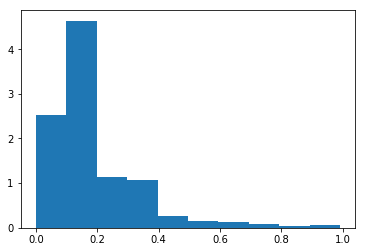

In [99]:
plt.hist(features['liveness'],density=True)

We're only interested in examining the studio versions. Since we'll focus on track and album similarity we want as little track repetitions or variations as possible. This means we'll get rid of demo and live versions. Most tracks are low in liveness anyway. 

In [100]:
albums = albums[~albums.album_name.str.contains('Live')]
albums = albums[~albums.album_name.str.contains('Deluxe')]

tracks = tracks[~(tracks.name.str.contains('Demo') & ~tracks.name.str.startswith('Demo'))]
tracks = tracks[~(tracks.name.str.contains('Live') 
                & ~ tracks.name.str.match('Live') 
                & ~tracks.name.isin(["Waking Lives","If I Could Live in This Montage,","I Would Rather Live Alone (I'm Not Who I'm Today)"]) )]

In [101]:
data = features.merge(tracks, on='id')
data  = data.merge(albums, on = 'album_id')
data = data.merge(artists[['artist_id','artist_name']], on='artist_id')

#get rid of christmas cover songs
data = data[~data.name.isin(["O Come, All Ye Faithful", "Silent Night", "O Holy Night",
                             "O Holy Night (Coke Studio)", "Jingle Bells", "Jingle Bells x Deck The Halls",
                            "Pasko, Pasko", "Pasko Na Sinta Ko - Live", "I'll Be Home For Christmas - Live",
                            "I'll Be Home for Christmas", "12 Days of Christmas", "This Christmas",
                             "Hark The Herald Angels Sing"])]

artists = artists[artists['artist_id'].isin(data.artist_id.unique())]
top_tracks = top_tracks.merge(data[['id','artist_name','album_name','release_date','acousticness', 'danceability', 'duration_ms', 'energy',
                                    'instrumentalness', 'key', 'loudness', 'mode', 'speechiness',
                                    'tempo', 'time_signature', 'valence']], on='id')

In [102]:
#if the exact same song was released as a single and as part of an album, we remove the single
duplicate_tracks = data[data.duplicated(subset=['name','artist_name'], keep=False)]
duplicate_tracks_same_albumtype = duplicate_tracks[duplicate_tracks.duplicated(subset=['name','artist_name','album_type'], keep=False)]
duplicate_tracks = duplicate_tracks.drop(labels=duplicate_tracks_same_albumtype.index) 
duplicate_tracks = duplicate_tracks[duplicate_tracks.album_type =='single'] 
data = data.drop(labels=duplicate_tracks.index)

In [103]:
#if it's part of the top tracks we get rid of the one not in the top tracks
duplicate_tracks_singles = duplicate_tracks_same_albumtype[duplicate_tracks_same_albumtype.album_type=='single']
match = duplicate_tracks_singles[duplicate_tracks_singles.id.isin(top_tracks.id)]
match_duplicate = duplicate_tracks_singles[duplicate_tracks_singles.name.isin(match.name.values) & duplicate_tracks_singles.artist_name.isin(match.artist_name.values)]
match_duplicate = match_duplicate.drop(labels = match.index)
data = data.drop(labels=match_duplicate.index)

In [104]:
#checked the tracks on spotify to figure out which to remove
duplicate_tracks_singles = data[data.duplicated(subset=['name','artist_name', 'album_type'], keep=False)]
duplicate_tracks_singles = duplicate_tracks_singles[duplicate_tracks_singles.album_type =='single'] 

In [105]:
data = data[~data.id.isin(['2EdGN7t9iqfO2nQuzYmwtG','2r8NNirF7wIVWgYub05M28','19W2Yf1HWW8t42X536FyiO',
                          '4bRUhryXD1j6yH8FhurXP5','4XMFzTqFfVg2kbg8QWZg3u','2PMwoczOBblVyWnPv1AtOK',
                          '2AVVScsrYvCaJEa0Em0nP3','7CPaxX4NpDCAsHu6l7Wgrf','1U2AAyiQxaAmhexAGbRBt5',
                          '2nj701qBR2sUQJJwIQDfH0','4gnB8ajjzYLUcT1fdP5Xgs','0pCVtVr8WwPfmi18UuJeoB',
                          '3EPi83nymQT8xpyhhkR97A','4Z96PCBJCm7luUC9pul1V6','1s1CzHJsngw5WepCKil5bx',
                          '5PZa3SFw3E4zvOCZwsxihx', '7Ipw44VKIGX8hAiyk5IWiB','21ZkQygETuUniq6QhD3R8k',
                          '2i6NSpxbELpP2W11bUOOwh','0NILwN8sesaYEfqZIqv3Ds','7o4wWaDR0cTcnOWD385o3O',
                          '0RsKqAMubnBiTeWl0gEzYY','6BhdY5rR9rCpSg5SJ8p68x', '6V8wIcmN2mmTGboC3mvpJ0',
                          '6jurqeA0oGtBq4AVZzFmwc','3D3iU9Lm7wsqxDHBPyuWGg','5R1FjVfqZgqaYZfdfCh3tf'])]

In [106]:
#there are still album duplicates, just not in the form of singles
duplicate_album_tracks = data[['name','artist_name','album_name','album_type','album_id']][data.duplicated(subset=['name','artist_name'], keep=False)]

In [107]:
#went through the all tracks to figure out which album and track to drop
data = data[~data.album_id.isin(['3KmhojVqDuGn5uHTvOPTyP','3S2wn2Fgagoh2kNAJHLL7D','6TwoE5Sbm4Ek6aA7wB4CrD',
                                '5240CJIWWatn8QeZz1e6Ch', '30IkggYSvncYoWo5LrzJrw'])]

3KmhojVqDuGn5uHTvOPTyP - extra info behind the songs and the album

3S2wn2Fgagoh2kNAJHLL7D,6TwoE5Sbm4Ek6aA7wB4CrD - open.spotify.com had the same two albums but with different album links for each. The album the spotify app linked to was chosen to remain.

5240CJIWWatn8QeZz1e6Ch - live songs

30IkggYSvncYoWo5LrzJrw - same songs but with a different naming scheme

We'll remove tracks shorter than a minute since most of them are used as intros or album fillers, like Maya, a 39 second track of birds chirping. 


Other fillers include:

CLAPCLAPCLAP! which is a short track with only clapping.

Obligatory Hipster Filler (0:13) which sounds like someone opening a box.

In [108]:
og_len = len(data)
data = data[data.duration_ms > 60000] #60000 miliseconds is a minute
print(og_len-len(data))
print((og_len-len(data))/og_len)

34
0.014623655913978495


That gets rid of 34 tracks, which accounts for 1.4% of the population count.

In [109]:
#tracks that have more than one artist
data_multiple_artists = data[['id','name','album_name','album_type','artist_name']][data.duplicated(subset=['id'], keep=False)].sort_values(by=['name'])

#only keep one track for tracks that have multiple artists
mult_artists_drop = data[data.duplicated(subset=['id'])]
data = data.drop(labels=mult_artists_drop.index)

# Spotify Audio Features

Spotify makes recommendations based on the following features:

    
Mood: Danceability, Valence, Energy, Tempo

Properties: Loudness, Speechiness, Instrumentalness

Context: Liveness, Acousticness

Segments, Tatums, Bars, Beats, Pitches, Timbre, and more


In [110]:
data.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'name',
       'preview_url', 'album_id', 'album_type', 'artist_id', 'image_300',
       'image_64', 'image_640', 'album_name', 'release_date', 'artist_name'],
      dtype='object')

In [111]:
col = ['acousticness','danceability','energy','instrumentalness','speechiness','valence','loudness','tempo']

### Track Similarity

We'll start with the columns above since each has one value for each track, whereas the segments, tatums etc. have multiple.

Echonest, and by extension Spotify, used these features as a basis for their music recommendations.

However, unlike Spotify, we won't include liveness.

Text(0.5, 1.0, 'Track Similarity Distribution')

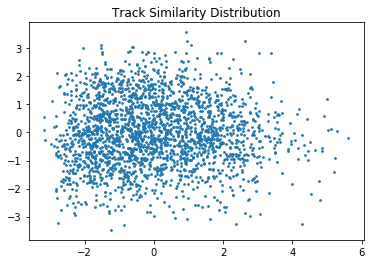

In [112]:
#PCA with normalization
X = data[col]

#we need to scale since the loudness is measured in decibels
scaler = StandardScaler()
standardized_X = scaler.fit_transform(X)

reduced_data = PCA(n_components=2).fit_transform(standardized_X)

plt.scatter(reduced_data[:,0],reduced_data[:,1], s=3) 
plt.title("Track Similarity Distribution")

In [113]:
test = pd.DataFrame(reduced_data)
test['name'] = data['name'].values
test['artist_name'] = data['artist_name'].values
upper_0 = test[test[0]>5].sort_values([0], ascending=False)
upper_0

0         1                           name    artist_name
1952  5.615921 -0.214522                     Riverchild    Clara Benin
1949  5.281248  0.058107                       December    Clara Benin
1564  5.239802 -0.924688                         Falter         lluwin
1557  5.187773 -1.417891                           Born         lluwin
2087  5.124650  0.110414  Slide (feat. Keiko Necesario)  Dane Hipolito
1948  5.023796  0.083131      Riverchild - Instrumental    Clara Benin

In [114]:
upper_1 = test[test[1]>3].sort_values([1], ascending=False)
upper_1

0         1                             name         artist_name
813   0.913661  3.564131  Kumusta Kadiliman - Spoken Word  Juan Miguel Severo
333   0.942588  3.263129                     Grammar Nazi     Reese Lansangan
1274  2.643302  3.262140                            Hanap             Because
1731 -1.512707  3.102369                      SakaLawakan   Assembly Generals
1983  1.058454  3.098781                        Palpitate                Asch
1097 -0.639893  3.038671            Process (feat. Awich)       Jess Connelly
365  -0.604938  3.032326                        Manlalako        Bullet Dumas
1232 -1.518026  3.024338                    Bobby Bobbito          Bawal Clan
1736 -2.058328  3.005251                 Fire in the Hole   Assembly Generals

Text(0.5, 1.0, 'Track Similarity Distribution')

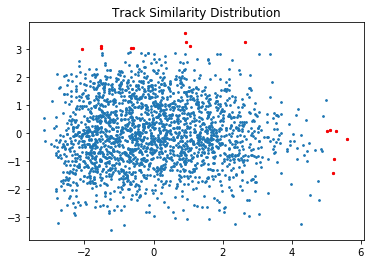

In [115]:
plt.scatter(reduced_data[:,0],reduced_data[:,1], s=3) 
plt.scatter(upper_0[0],upper_0[1], s=5, color='red') 
plt.scatter(upper_1[0],upper_1[1], s=5, color='red') 

plt.title("Track Similarity Distribution")

It's not clear why these tracks are far from the rest.

Let's take a look at the distribution of the features.

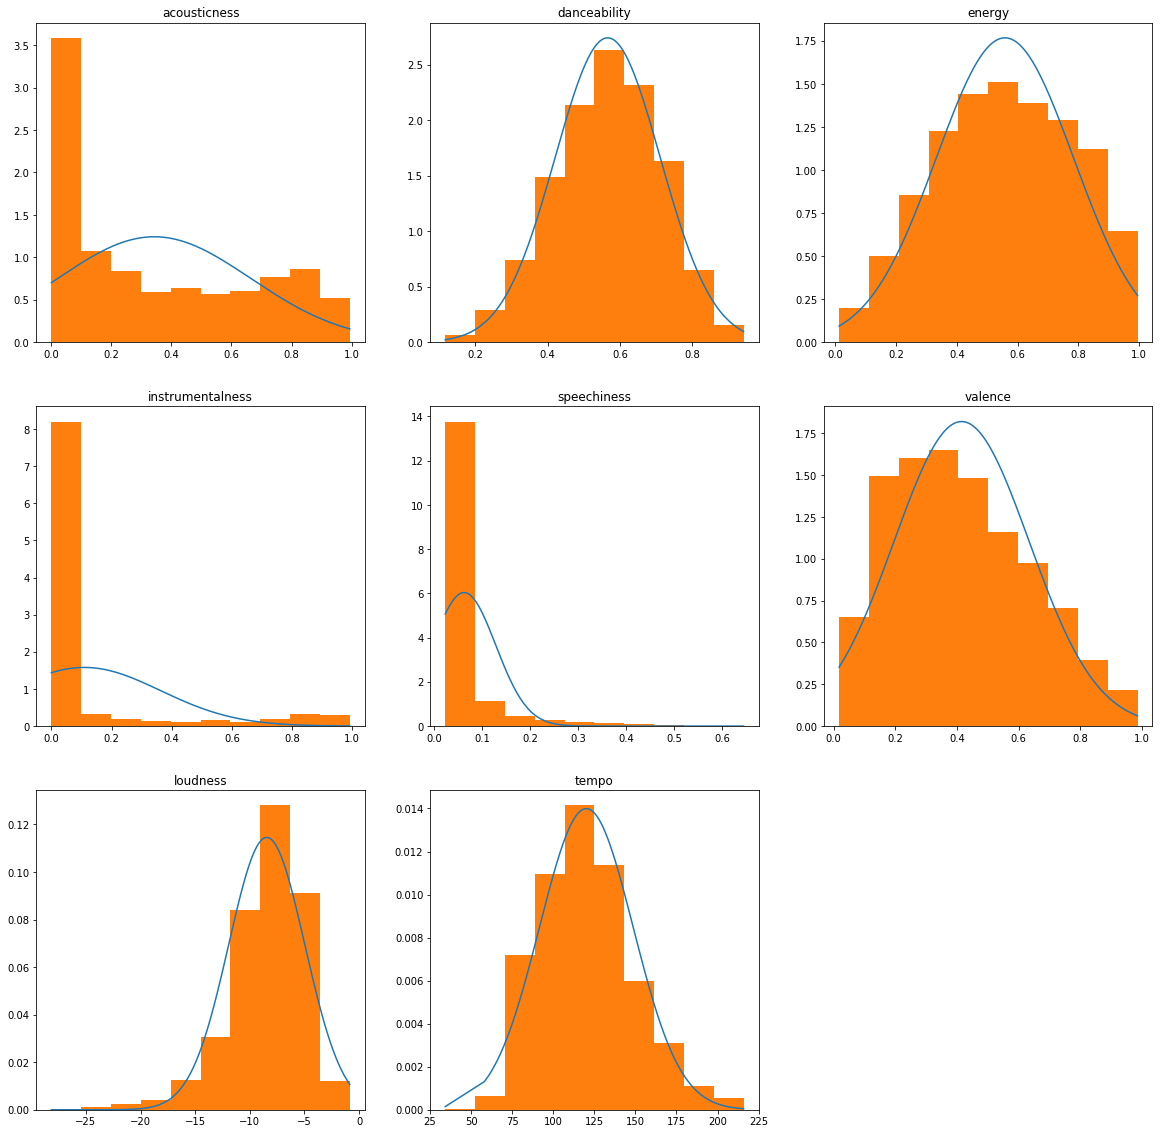

In [116]:
plt.figure(figsize=(20,20))
for idx, column in enumerate(X.columns):
    h = sorted(X[column])  #sorted
    fit = stats.norm.pdf(h, np.mean(h), np.std(h))
    
    plt.subplot(3,3,idx+1)
    plt.plot(h,fit)
    plt.hist(h,density=True) 
    plt.title(column)

     #use this to draw histogram of your data
plt.show()

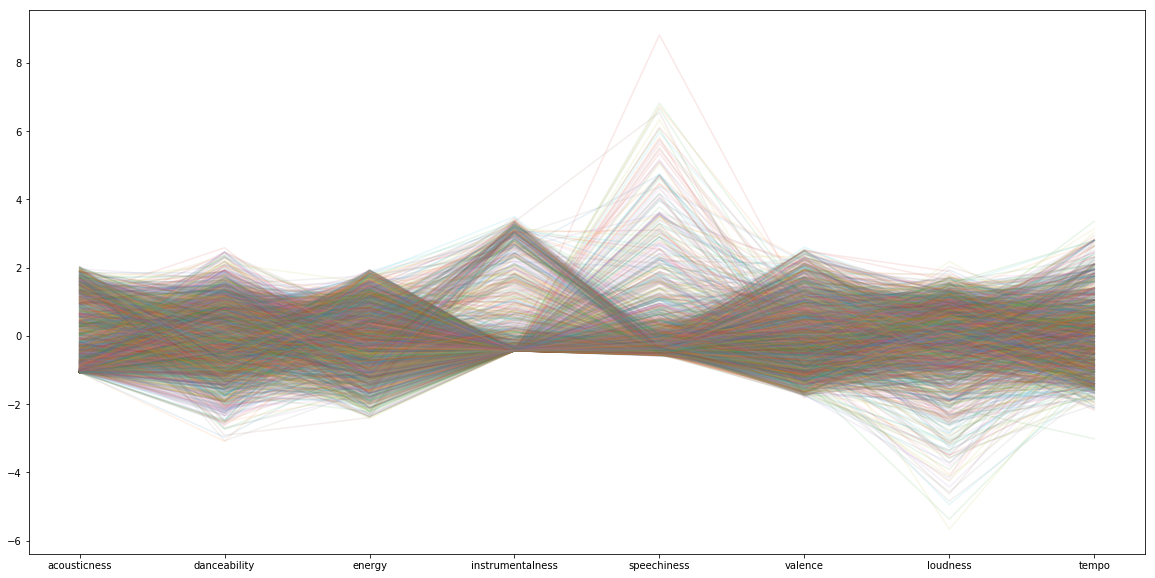

In [117]:
#Standard Scaler 
scaler = StandardScaler() 
#we need to scale since the loudness is measured in decibels
Y = pd.DataFrame(scaler.fit_transform(X), columns = col)

plt.figure(figsize=(20,10))
line = plt.plot(Y.columns, Y.T,alpha=0.1)

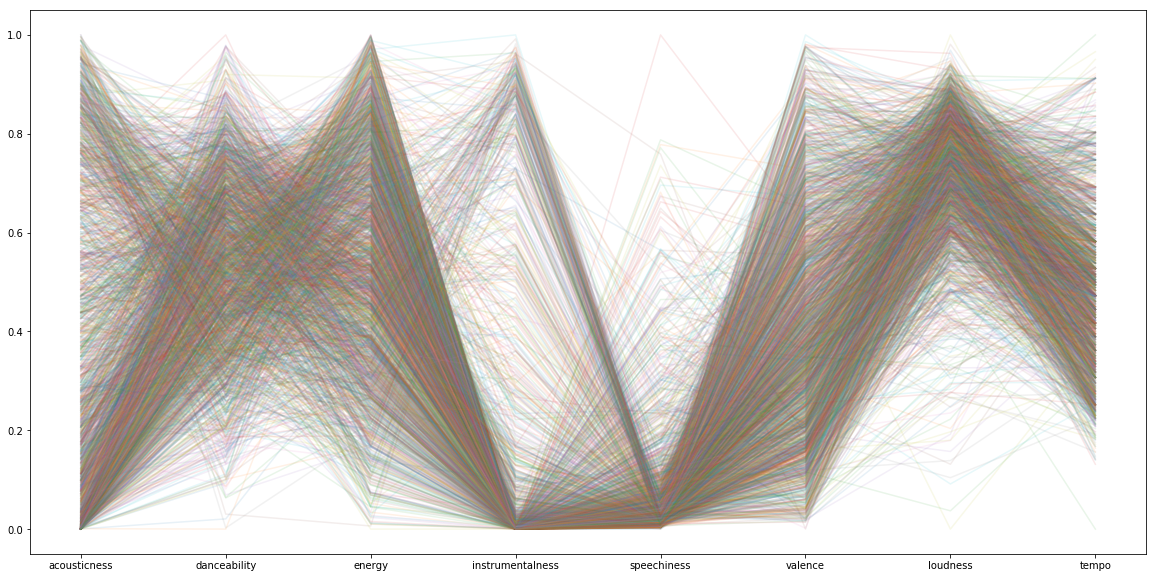

In [118]:
#Min-max scaler is sensitive to outliers
minmax_scaler = MinMaxScaler() 
#we need to scale since the loudness is measured in decibels
Y_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), columns = col)

plt.figure(figsize=(20,10))
line = plt.plot(Y_minmax.columns, Y_minmax.T,alpha=0.1)

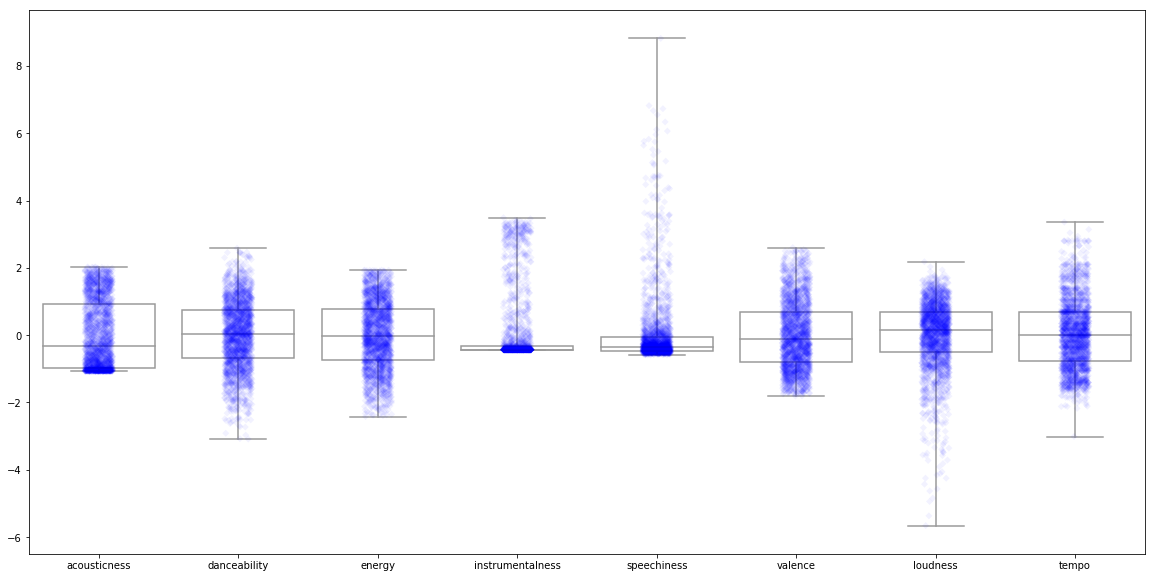

In [119]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=Y, whis=np.inf, color='white')
ax = sns.stripplot(data=Y, color="blue",alpha=.05, marker='D', edgecolor="black")

In [120]:
X.describe()

acousticness  danceability       energy  instrumentalness  speechiness  \
count   2276.000000   2276.000000  2276.000000       2276.000000  2276.000000   
mean       0.342769      0.566082     0.558499          0.109832     0.062326   
std        0.320997      0.145484     0.225726          0.252593     0.066082   
min        0.000004      0.117000     0.012600          0.000000     0.023200   
25%        0.033975      0.466000     0.390000          0.000002     0.032000   
50%        0.242000      0.571000     0.556000          0.000257     0.039200   
75%        0.642000      0.674000     0.736250          0.025025     0.059100   
max        0.994000      0.942000     0.995000          0.992000     0.645000   

           valence     loudness        tempo  
count  2276.000000  2276.000000  2276.000000  
mean      0.415174    -8.445936   120.138124  
std       0.219260     3.483563    28.516151  
min       0.017900   -28.157000    34.251000  
25%       0.237000   -10.149250    98.058000  
50%       0.389500    -7.918500   119.921000  
75%       0.569000    -6.056500   139.384750  
max       0.986000    -0.849000   215.900000

Most songs are close to zero in acousticness, with a somewhat even distribution for the other values of acousticness. 

Danceability tends to cluster around the mean 0.56, suggesting that most songs are moderate in danceability. There are outliers on the low end of danceability.

Energy and valence are varied--their means are close to 0.5 and have a skewed distribution.

Majority of the songs rank are close to zero in instrumentalness and speechiness. Both have heavy tails. 

Most songs are loud. 

Tempo averages to about 120 bpm and have few outliers with a high tempo and one with a low tempo.

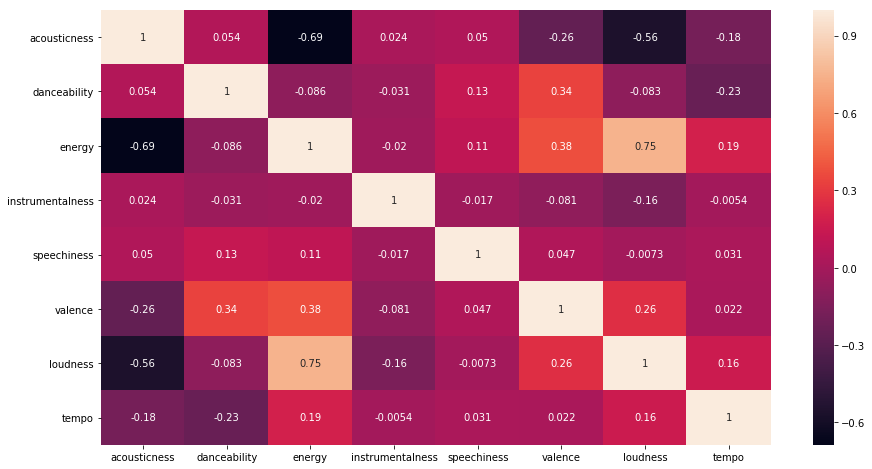

In [121]:
plt.figure(figsize=(15, 8))
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=X.columns.values,
            yticklabels=X.columns.values,
            annot=True)

Noticeable positive correlations:

Energy and loudness - This makes sense. Typically, energetic tracks feel fast, loud, and noisy.

Noticeable negative correlations:

Acousticness and energy

Acousticness and loudness

The rest have little correlation. I'm surprised that energy and danceability aren't correlated.

Let's group the tracks based on feature similarity.

Text(0, 0.5, 'Sum of squared distance')

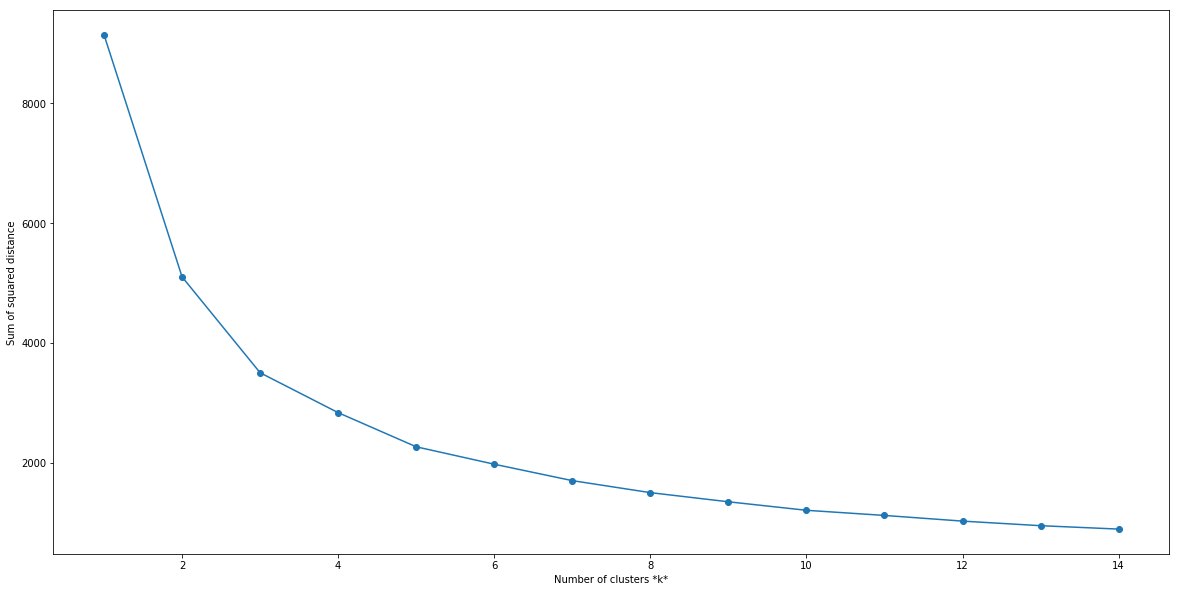

In [122]:
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(reduced_data)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(20, 10))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Elbow method used to determine the number of clusters.

In [123]:
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(reduced_data)

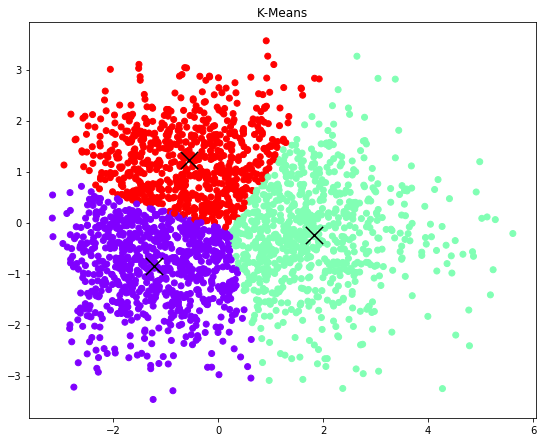

In [124]:
plt.figure(figsize=(20,16))
plt.subplot(221, title='K-Means')
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=kmeans.labels_, cmap='rainbow')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=300, linewidths=3,
            color='black', zorder=10)

In [125]:
clustered_data = X
clustered_data['cluster'] = kmeans.labels_
print(len(clustered_data))
clustered_data['id'] = data['id'].values
print(len(clustered_data))
clustered_data['name'] = data['name'].values
print(len(clustered_data))
clustered_data['artist_name'] = data['artist_name'].values
print(len(clustered_data))
print(len(clustered_data))
clustered_data.head()

2276
2276
2276
2276
2276


/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

acousticness  danceability  energy  instrumentalness  speechiness  valence  \
0         0.936         0.534   0.178          0.000000       0.0341    0.300   
1         0.229         0.515   0.529          0.000077       0.0466    0.181   
2         0.920         0.584   0.186          0.000000       0.0422    0.238   
3         0.964         0.508   0.252          0.000001       0.0274    0.251   
5         0.174         0.686   0.674          0.000025       0.0248    0.664   

   loudness    tempo  cluster                      id  \
0   -11.953   94.948        1  3kFDnFj6asUJsUPodsWT2o   
1    -9.493  127.424        0  1I4FVXxMHTy07BvPO1mVjA   
2    -9.272  107.885        1  2IFNR24j14O8IuqLxFr0NT   
3    -7.917  140.185        1  4FrzR2A8kmSKB87Nx2oZjR   
5    -6.303  110.965        2  2vqAmth0yZZbBxwmVdE9V2   

                                    name      artist_name  
0  Away from the Current (Piano Version)  Keiko Necesario  
1                                 Blithe  Keiko Necesario  
2                      Let Me Be The One  Keiko Necesario  
3                            Ikaw Pa Rin  Keiko Necesario  
5                              Panaginip  Keiko Necesario

In [126]:
clustered_data[clustered_data['cluster']==0]

acousticness  danceability  energy  instrumentalness  speechiness  \
1         0.229000         0.515   0.529          0.000077       0.0466   
10        0.482000         0.502   0.551          0.000267       0.0422   
18        0.034200         0.229   0.697          0.000000       0.0304   
20        0.005570         0.469   0.749          0.000000       0.0358   
21        0.004870         0.498   0.820          0.000000       0.0365   
24        0.022800         0.415   0.524          0.000005       0.0287   
25        0.235000         0.581   0.750          0.000000       0.0324   
28        0.612000         0.311   0.468          0.000000       0.0295   
30        0.001760         0.441   0.826          0.000042       0.0653   
35        0.098900         0.512   0.506          0.000007       0.0286   
36        0.083200         0.571   0.777          0.000012       0.0333   
38        0.003630         0.535   0.715          0.000000       0.0343   
41        0.028200         0.561   0.805          0.000000       0.0333   
43        0.005910         0.613   0.520          0.650000       0.0342   
46        0.005030         0.592   0.739          0.015600       0.0399   
47        0.049300         0.596   0.735          0.000460       0.0372   
48        0.039400         0.599   0.825          0.023500       0.0383   
49        0.002040         0.566   0.818          0.006840       0.0266   
50        0.002160         0.475   0.892          0.002760       0.0360   
51        0.003570         0.610   0.686          0.135000       0.0345   
52        0.000213         0.546   0.926          0.168000       0.0393   
53        0.005420         0.498   0.807          0.015700       0.0330   
54        0.000147         0.562   0.869          0.004000       0.0565   
56        0.020600         0.610   0.551          0.000002       0.0304   
59        0.015900         0.605   0.795          0.054500       0.0317   
61        0.133000         0.577   0.506          0.000419       0.0370   
62        0.011500         0.576   0.848          0.000001       0.0401   
64        0.001450         0.593   0.864          0.000000       0.0346   
68        0.000266         0.370   0.954          0.005750       0.0927   
69        0.023100         0.531   0.851          0.000669       0.0431   
...            ...           ...     ...               ...          ...   
2462      0.550000         0.493   0.635          0.000002       0.0285   
2463      0.590000         0.544   0.801          0.812000       0.0285   
2464      0.013800         0.524   0.841          0.000170       0.0445   
2465      0.022100         0.504   0.726          0.720000       0.0322   
2467      0.001260         0.360   0.562          0.000000       0.0404   
2468      0.008950         0.461   0.781          0.000791       0.0528   
2471      0.250000         0.585   0.694          0.000002       0.0278   
2473      0.355000         0.425   0.658          0.000002       0.0349   
2475      0.022600         0.499   0.558          0.000558       0.0257   
2485      0.448000         0.399   0.486          0.000000       0.0281   
2487      0.471000         0.475   0.704          0.000000       0.0508   
2489      0.246000         0.544   0.610          0.000004       0.0635   
2494      0.291000         0.325   0.413          0.000003       0.0366   
2504      0.488000         0.639   0.692          0.783000       0.0614   
2518      0.008110         0.557   0.808          0.000027       0.0361   
2521      0.005160         0.573   0.878          0.000221       0.0459   
2528      0.230000         0.449   0.829          0.402000       0.0406   
2530      0.014900         0.465   0.914          0.000000       0.1150   
2531      0.714000         0.500   0.594          0.000048       0.0280   
2533      0.000060         0.445   0.955          0.026500       0.0695   
2534      0.000945         0.464   0.866          0.004630       0.0486   
2535      0.000074         0.42

Why was it grouped this way? 

In [127]:
clustered_data[clustered_data['artist_name']=='Keiko Necesario']

acousticness  danceability  energy  instrumentalness  speechiness  \
0         0.9360         0.534   0.178          0.000000       0.0341   
1         0.2290         0.515   0.529          0.000077       0.0466   
2         0.9200         0.584   0.186          0.000000       0.0422   
3         0.9640         0.508   0.252          0.000001       0.0274   
5         0.1740         0.686   0.674          0.000025       0.0248   
6         0.8390         0.331   0.150          0.000007       0.0338   
7         0.8760         0.423   0.208          0.000016       0.0362   
9         0.8930         0.415   0.107          0.000000       0.0398   
10        0.4820         0.502   0.551          0.000267       0.0422   
12        0.0341         0.813   0.596          0.000008       0.0487   
13        0.1980         0.485   0.663          0.000061       0.0963   
14        0.6580         0.542   0.518          0.013100       0.0301   
15        0.0721         0.658   0.776          0.000001       0.1130   

    valence  loudness    tempo  cluster                      id  \
0     0.300   -11.953   94.948        1  3kFDnFj6asUJsUPodsWT2o   
1     0.181    -9.493  127.424        0  1I4FVXxMHTy07BvPO1mVjA   
2     0.238    -9.272  107.885        1  2IFNR24j14O8IuqLxFr0NT   
3     0.251    -7.917  140.185        1  4FrzR2A8kmSKB87Nx2oZjR   
5     0.664    -6.303  110.965        2  2vqAmth0yZZbBxwmVdE9V2   
6     0.188   -14.474  124.085        1  39fNON9tzWSkuLbpGAHJnD   
7     0.234   -12.925  138.778        1  23GURsZ8hfMKVjUpm16IMq   
9     0.270   -12.278  125.344        1  06AxnsCACcLbrkVVCA6UCv   
10    0.291    -8.494  171.988        0  6b5pWdPQy9i85vBZR3pl2T   
12    0.706    -7.322  116.067        2  54Xd504CFfd9jWTcpNPg2U   
13    0.701    -9.718   84.684        2  0ghwbO2V01fXhpMMwx0sw1   
14    0.185   -10.861  148.051        1  6KCKbh4PXZGP7Rykg2v6gj   
15    0.546    -7.040  148.096        2  7MwvSPbO4n8hVVM8Hdjg7F   

                                     name      artist_name  
0   Away from the Current (Piano Version)  Keiko Necesario  
1                                  Blithe  Keiko Necesario  
2                       Let Me Be The One  Keiko Necesario  
3                             Ikaw Pa Rin  Keiko Necesario  
5                               Panaginip  Keiko Necesario  
6                              Connection  Keiko Necesario  
7               Maybe in Another Lifetime  Keiko Necesario  
9                               Paano Na?  Keiko Necesario  
10                             Di Bale Na  Keiko Necesario  
12                     While We Are Young  Keiko Necesario  
13                                Highway  Keiko Necesario  
14                                 Escape  Keiko Necesario  
15                        Highway - Remix  Keiko Necesario

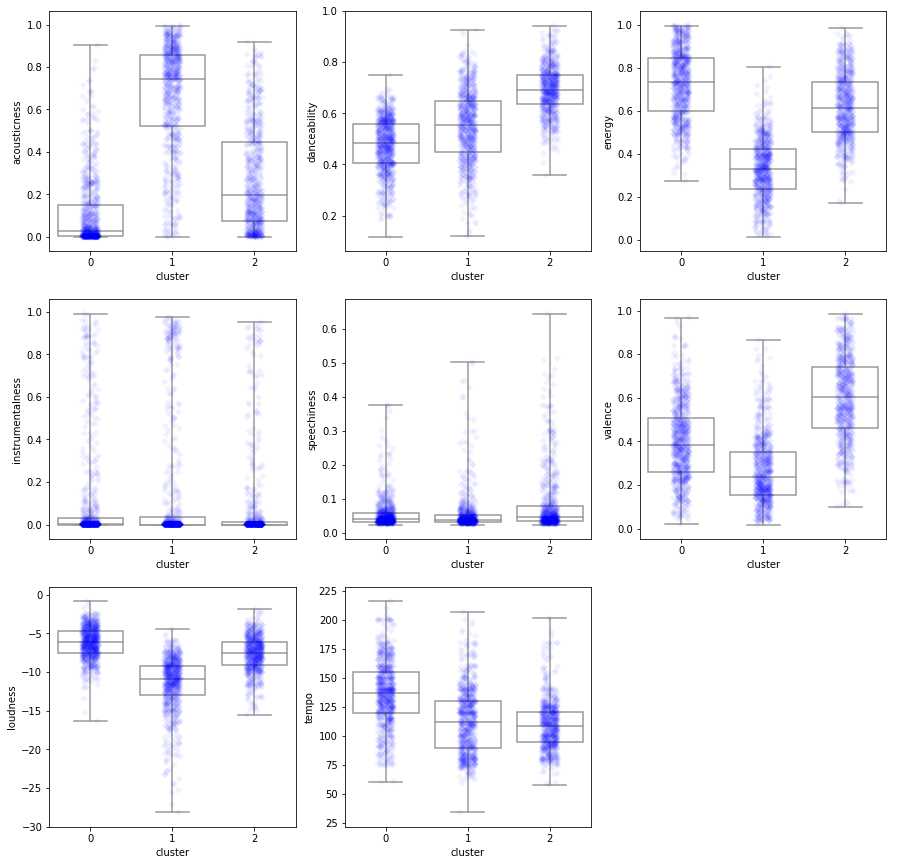

In [128]:
clustered_data_simplfified = clustered_data[['cluster','acousticness','danceability','energy','instrumentalness',
          'speechiness','valence','loudness','tempo']]

clustered_data_features = clustered_data[['acousticness','danceability','energy','instrumentalness',
          'speechiness','valence','loudness','tempo']]

plt.figure (figsize=(15,15))

for idx,cl in enumerate(clustered_data_features.columns):
    plt.subplot(3,3,idx+1)
    ax = sns.boxplot(x='cluster', y=cl, data=clustered_data_simplfified, whis=np.inf, color='white')
    ax = sns.stripplot(x='cluster', y=cl, data=clustered_data_simplfified, color="blue",alpha=.05, marker='D', edgecolor="black")


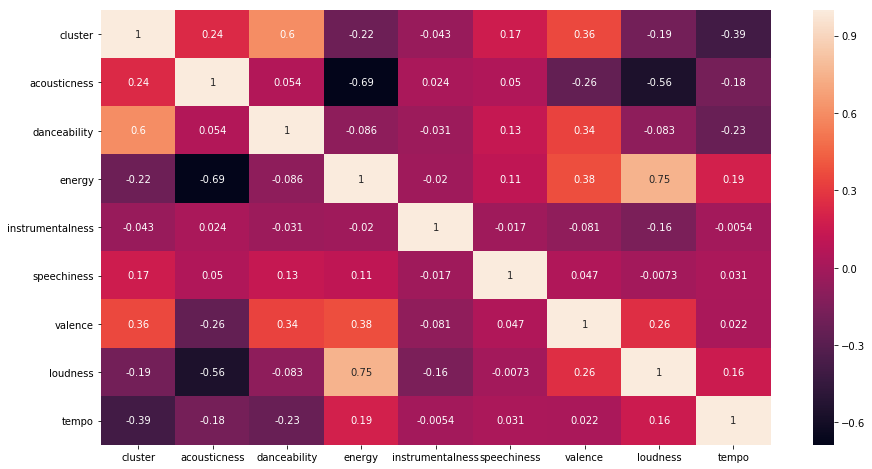

In [129]:
plt.figure(figsize=(15, 8))
cluster_corr = clustered_data_simplfified.corr()
sns.heatmap(cluster_corr, 
            xticklabels=cluster_corr.columns.values,
            yticklabels=cluster_corr.columns.values,
           annot=True)

### Track Mood

Let's take a closer look at the mood of the tracks.

Text(0.5, 1.0, 'Mood Similarity Distribution')

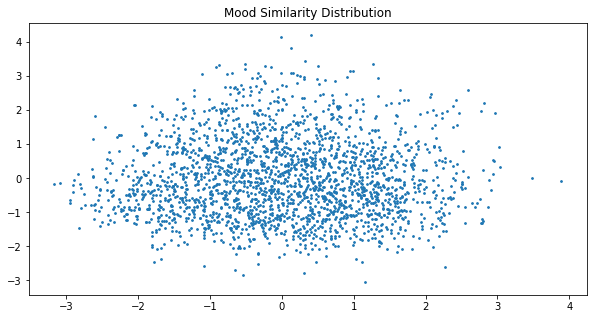

In [130]:
mood_X = Y[['danceability', 'valence', 'energy', 'tempo']]
reduced_mood = PCA(n_components=2).fit_transform(mood_X)

plt.figure(figsize=(10,5))

plt.scatter(reduced_mood[:,0],reduced_mood[:,1], s=3) 
plt.title("Mood Similarity Distribution")

Text(0, 0.5, 'Sum of squared distance')

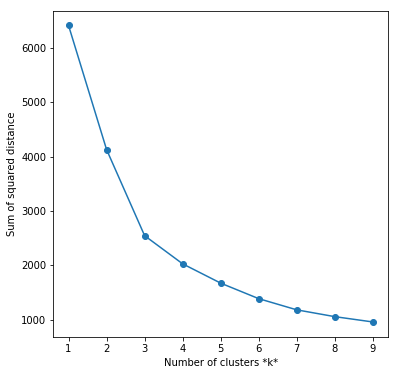

In [131]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(reduced_mood)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [132]:
kmeans = KMeans(n_clusters=3).fit(reduced_mood)

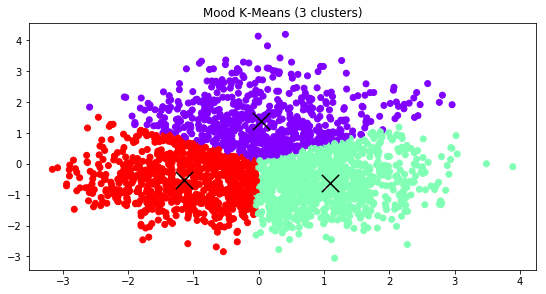

In [133]:
plt.figure(figsize=(20,10))
plt.subplot(221, title='Mood K-Means (3 clusters)')
plt.scatter(reduced_mood[:,0], reduced_mood[:,1], c=kmeans.labels_, cmap='rainbow')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=300, linewidths=3,
            color='black', zorder=10)


In [134]:
mood_cluster = X[['danceability', 'valence', 'energy', 'tempo']]
mood_cluster['cluster'] = kmeans.labels_
mood_cluster['name'] = data['name'].values
mood_cluster['artist_name'] = data['artist_name'].values
mood_cluster['id'] = data['id'].values
mood_cluster.head()

/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

danceability  valence  energy    tempo  cluster  \
0         0.534    0.300   0.178   94.948        1   
1         0.515    0.181   0.529  127.424        1   
2         0.584    0.238   0.186  107.885        1   
3         0.508    0.251   0.252  140.185        1   
5         0.686    0.664   0.674  110.965        2   

                                    name      artist_name  \
0  Away from the Current (Piano Version)  Keiko Necesario   
1                                 Blithe  Keiko Necesario   
2                      Let Me Be The One  Keiko Necesario   
3                            Ikaw Pa Rin  Keiko Necesario   
5                              Panaginip  Keiko Necesario   

                       id  
0  3kFDnFj6asUJsUPodsWT2o  
1  1I4FVXxMHTy07BvPO1mVjA  
2  2IFNR24j14O8IuqLxFr0NT  
3  4FrzR2A8kmSKB87Nx2oZjR  
5  2vqAmth0yZZbBxwmVdE9V2

In [135]:
mood_cluster[mood_cluster['artist_name']=='Keiko Necesario']

danceability  valence  energy    tempo  cluster  \
0          0.534    0.300   0.178   94.948        1   
1          0.515    0.181   0.529  127.424        1   
2          0.584    0.238   0.186  107.885        1   
3          0.508    0.251   0.252  140.185        1   
5          0.686    0.664   0.674  110.965        2   
6          0.331    0.188   0.150  124.085        1   
7          0.423    0.234   0.208  138.778        1   
9          0.415    0.270   0.107  125.344        1   
10         0.502    0.291   0.551  171.988        0   
12         0.813    0.706   0.596  116.067        2   
13         0.485    0.701   0.663   84.684        2   
14         0.542    0.185   0.518  148.051        0   
15         0.658    0.546   0.776  148.096        2   

                                     name      artist_name  \
0   Away from the Current (Piano Version)  Keiko Necesario   
1                                  Blithe  Keiko Necesario   
2                       Let Me Be The One  Keiko Necesario   
3                             Ikaw Pa Rin  Keiko Necesario   
5                               Panaginip  Keiko Necesario   
6                              Connection  Keiko Necesario   
7               Maybe in Another Lifetime  Keiko Necesario   
9                               Paano Na?  Keiko Necesario   
10                             Di Bale Na  Keiko Necesario   
12                     While We Are Young  Keiko Necesario   
13                                Highway  Keiko Necesario   
14                                 Escape  Keiko Necesario   
15                        Highway - Remix  Keiko Necesario   

                        id  
0   3kFDnFj6asUJsUPodsWT2o  
1   1I4FVXxMHTy07BvPO1mVjA  
2   2IFNR24j14O8IuqLxFr0NT  
3   4FrzR2A8kmSKB87Nx2oZjR  
5   2vqAmth0yZZbBxwmVdE9V2  
6   39fNON9tzWSkuLbpGAHJnD  
7   23GURsZ8hfMKVjUpm16IMq  
9   06AxnsCACcLbrkVVCA6UCv  
10  6b5pWdPQy9i85vBZR3pl2T  
12  54Xd504CFfd9jWTcpNPg2U  
13  0ghwbO2V01fXhpMMwx0sw1  
14  6KCKbh4PXZGP7Rykg2v6gj  
15  7MwvSPbO4n8hVVM8Hdjg7F

Why were they clustered this way? What mood can we attribute to each cluster? Let's see if there's any correlation between their cluster and feature.

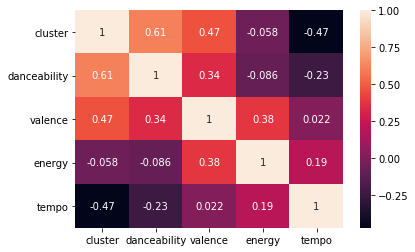

In [136]:
mood_corr = mood_cluster[['cluster','danceability', 'valence', 'energy', 'tempo']]
corr = mood_corr.corr()
sns.heatmap(corr, 
            xticklabels=mood_corr.columns.values,
            yticklabels=mood_corr.columns.values,
           annot=True)

In [137]:
mood_0 = mood_cluster[mood_cluster['cluster']==0]

mood_0 = mood_0[['danceability', 'valence', 'energy', 'tempo']]
mood_0.describe()

danceability     valence      energy      tempo
count    657.000000  657.000000  657.000000  657.00000
mean       0.446449    0.378815    0.699121  146.91123
std        0.106605    0.168984    0.190793   24.74335
min        0.117000    0.019600    0.056700   74.89100
25%        0.381000    0.255000    0.569000  130.10700
50%        0.454000    0.372000    0.724000  146.06300
75%        0.528000    0.480000    0.844000  165.17200
max        0.729000    0.960000    0.995000  215.90000

In [138]:
mood_cluster[mood_cluster['cluster']==0].head()

danceability  valence  energy    tempo  cluster        name  \
10         0.502    0.291   0.551  171.988        0  Di Bale Na   
14         0.542    0.185   0.518  148.051        0      Escape   
18         0.229    0.292   0.697  152.236        0  Bawat Daan   
19         0.555    0.420   0.347  151.917        0     Kasayaw   
20         0.469    0.331   0.749  144.123        0        Prom   

        artist_name                      id  
10  Keiko Necesario  6b5pWdPQy9i85vBZR3pl2T  
14  Keiko Necesario  6KCKbh4PXZGP7Rykg2v6gj  
18       Ebe Dancel  0wUSZjJVblGKntOqBSWMdo  
19       Ebe Dancel  1PylPQlmQ2ymbRFtEqs3NM  
20       Ebe Dancel  461EfHiwzh8ZCZGaFEIaAJ

In [139]:
mood_cluster[mood_cluster['cluster']==1].head()

danceability  valence  energy    tempo  cluster  \
0         0.534    0.300   0.178   94.948        1   
1         0.515    0.181   0.529  127.424        1   
2         0.584    0.238   0.186  107.885        1   
3         0.508    0.251   0.252  140.185        1   
6         0.331    0.188   0.150  124.085        1   

                                    name      artist_name  \
0  Away from the Current (Piano Version)  Keiko Necesario   
1                                 Blithe  Keiko Necesario   
2                      Let Me Be The One  Keiko Necesario   
3                            Ikaw Pa Rin  Keiko Necesario   
6                             Connection  Keiko Necesario   

                       id  
0  3kFDnFj6asUJsUPodsWT2o  
1  1I4FVXxMHTy07BvPO1mVjA  
2  2IFNR24j14O8IuqLxFr0NT  
3  4FrzR2A8kmSKB87Nx2oZjR  
6  39fNON9tzWSkuLbpGAHJnD

In [140]:
mood_cluster[mood_cluster['cluster']==2].head()

danceability  valence  energy    tempo  cluster  \
5          0.686    0.664   0.674  110.965        2   
12         0.813    0.706   0.596  116.067        2   
13         0.485    0.701   0.663   84.684        2   
15         0.658    0.546   0.776  148.096        2   
25         0.581    0.681   0.750  144.068        2   

                               name      artist_name                      id  
5                         Panaginip  Keiko Necesario  2vqAmth0yZZbBxwmVdE9V2  
12               While We Are Young  Keiko Necesario  54Xd504CFfd9jWTcpNPg2U  
13                          Highway  Keiko Necesario  0ghwbO2V01fXhpMMwx0sw1  
15                  Highway - Remix  Keiko Necesario  7MwvSPbO4n8hVVM8Hdjg7F  
25  Padayon - Theme from Kid Kulafu       Ebe Dancel  10KwgxxuINm8qfrscMSyog

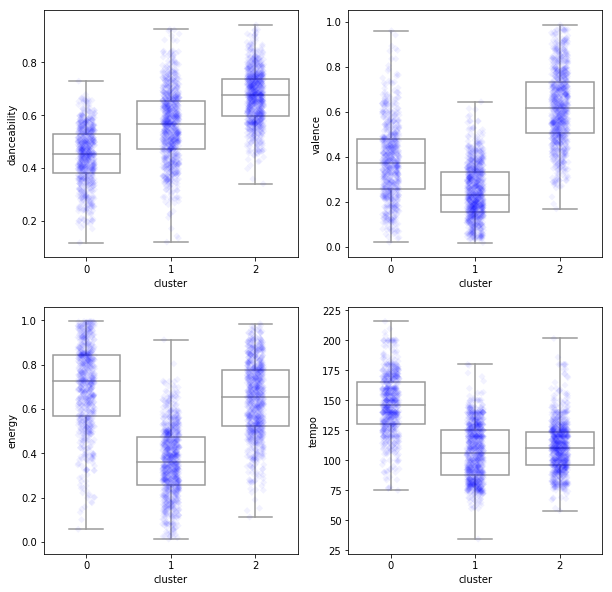

In [141]:
plt.figure (figsize=(10,10))

for idx,col in enumerate(mood_0.columns):
    plt.subplot(2,2,idx+1)
    ax = sns.boxplot(x='cluster', y=col, data=mood_corr, whis=np.inf, color='white')
    ax = sns.stripplot(x='cluster', y=col, data=mood_corr, color="blue",alpha=.05, marker='D', edgecolor="black")


### Track Properties

Text(0.5, 1.0, 'Property Similarity Distribution')

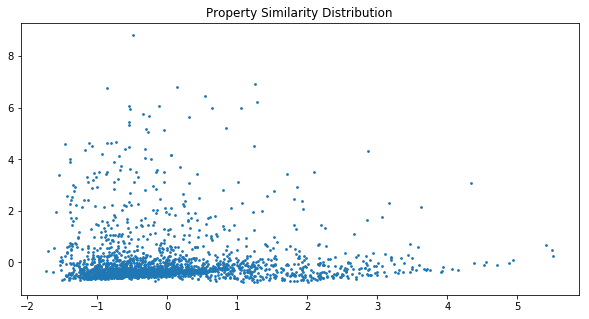

In [142]:
properties = ['loudness', 'speechiness', 'instrumentalness']
properties_X = scaler.fit_transform(X[properties])
reduced_properties = PCA(n_components=2).fit_transform(properties_X)

plt.figure(figsize=(10,5))

plt.scatter(reduced_properties[:,0],reduced_properties[:,1], s=3) 
plt.title("Property Similarity Distribution")

Text(0, 0.5, 'Sum of squared distance')

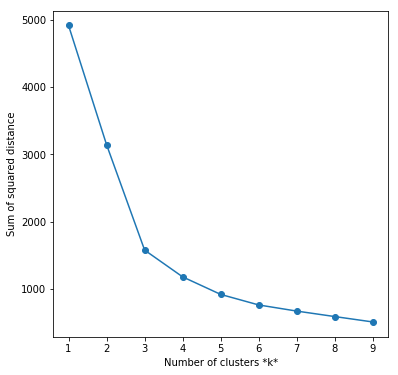

In [143]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(reduced_properties)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [144]:
kmeans = KMeans(n_clusters=3).fit(reduced_properties)

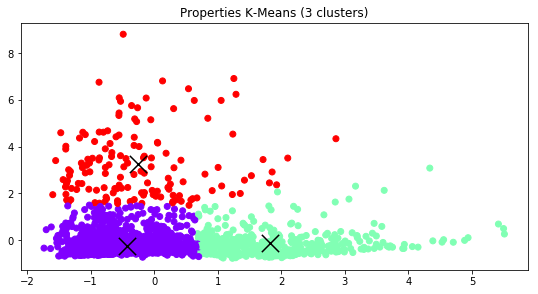

In [145]:
plt.figure(figsize=(20,10))
plt.subplot(221, title='Properties K-Means (3 clusters)')
plt.scatter(reduced_properties[:,0], reduced_properties[:,1], c=kmeans.labels_, cmap='rainbow')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=300, linewidths=3,
            color='black', zorder=10)

In [146]:
properties_cluster = X[properties]
properties_cluster['cluster'] = kmeans.labels_
properties_cluster['name'] = data['name'].values
properties_cluster['artist_name'] = data['artist_name'].values
properties_cluster['id'] = data['id'].values
#properties_cluster = pd.concat([properties_cluster,Y[properties]], axis=1)
properties_cluster.head()

/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

loudness  speechiness  instrumentalness  cluster  \
0   -11.953       0.0341          0.000000        0   
1    -9.493       0.0466          0.000077        0   
2    -9.272       0.0422          0.000000        0   
3    -7.917       0.0274          0.000001        0   
5    -6.303       0.0248          0.000025        0   

                                    name      artist_name  \
0  Away from the Current (Piano Version)  Keiko Necesario   
1                                 Blithe  Keiko Necesario   
2                      Let Me Be The One  Keiko Necesario   
3                            Ikaw Pa Rin  Keiko Necesario   
5                              Panaginip  Keiko Necesario   

                       id  
0  3kFDnFj6asUJsUPodsWT2o  
1  1I4FVXxMHTy07BvPO1mVjA  
2  2IFNR24j14O8IuqLxFr0NT  
3  4FrzR2A8kmSKB87Nx2oZjR  
5  2vqAmth0yZZbBxwmVdE9V2

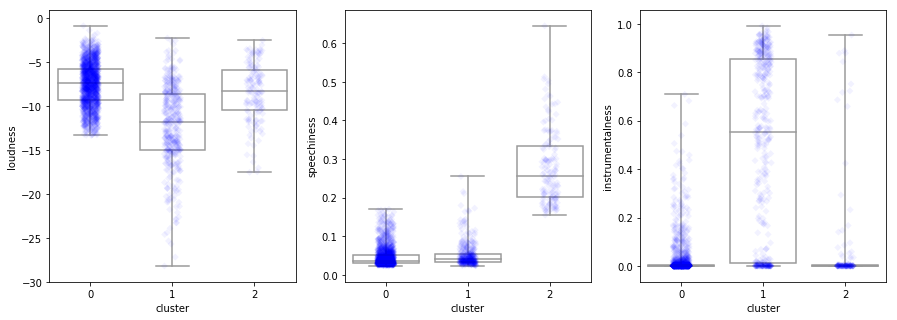

In [147]:
properties_cluster_simplified = properties_cluster[['cluster', 'loudness', 'speechiness', 'instrumentalness']]

plt.figure (figsize=(15,5))

for idx,col in enumerate(properties):
    plt.subplot(1,3,idx+1)
    ax = sns.boxplot(x='cluster', y=col, data=properties_cluster_simplified, whis=np.inf, color='white')
    ax = sns.stripplot(x='cluster', y=col, data=properties_cluster_simplified, color="blue",alpha=.05, marker='D', edgecolor="black")


In [148]:
properties_cluster[properties_cluster['cluster']==0].head(10)

loudness  speechiness  instrumentalness  cluster  \
0    -11.953       0.0341          0.000000        0   
1     -9.493       0.0466          0.000077        0   
2     -9.272       0.0422          0.000000        0   
3     -7.917       0.0274          0.000001        0   
5     -6.303       0.0248          0.000025        0   
7    -12.925       0.0362          0.000016        0   
9    -12.278       0.0398          0.000000        0   
10    -8.494       0.0422          0.000267        0   
12    -7.322       0.0487          0.000008        0   
13    -9.718       0.0963          0.000061        0   

                                     name      artist_name  \
0   Away from the Current (Piano Version)  Keiko Necesario   
1                                  Blithe  Keiko Necesario   
2                       Let Me Be The One  Keiko Necesario   
3                             Ikaw Pa Rin  Keiko Necesario   
5                               Panaginip  Keiko Necesario   
7               Maybe in Another Lifetime  Keiko Necesario   
9                               Paano Na?  Keiko Necesario   
10                             Di Bale Na  Keiko Necesario   
12                     While We Are Young  Keiko Necesario   
13                                Highway  Keiko Necesario   

                        id  
0   3kFDnFj6asUJsUPodsWT2o  
1   1I4FVXxMHTy07BvPO1mVjA  
2   2IFNR24j14O8IuqLxFr0NT  
3   4FrzR2A8kmSKB87Nx2oZjR  
5   2vqAmth0yZZbBxwmVdE9V2  
7   23GURsZ8hfMKVjUpm16IMq  
9   06AxnsCACcLbrkVVCA6UCv  
10  6b5pWdPQy9i85vBZR3pl2T  
12  54Xd504CFfd9jWTcpNPg2U  
13  0ghwbO2V01fXhpMMwx0sw1

In [149]:
properties_cluster[properties_cluster['cluster']==1].head(10)

loudness  speechiness  instrumentalness  cluster  \
6     -14.474       0.0338          0.000007        1   
43    -12.037       0.0342          0.650000        1   
71     -6.984       0.0316          0.503000        1   
76     -9.089       0.0499          0.791000        1   
79     -9.565       0.0261          0.521000        1   
81     -7.349       0.0300          0.777000        1   
86    -10.029       0.0371          0.600000        1   
102   -20.138       0.0458          0.826000        1   
103   -22.914       0.1050          0.027200        1   
104   -24.573       0.0731          0.909000        1   

                                   name       artist_name  \
6                            Connection   Keiko Necesario   
43       Padayon - Instrumental Version        Ebe Dancel   
71                             Buhangin          Sandwich   
76                        Bato-Bato Pik          Sandwich   
79                           Time Lapse          Sandwich   
81   Even If You Asked Me (Coke Studio)          Sandwich   
86                           Pretty Car  B. P. Valenzuela   
102                            Geomorph  B. P. Valenzuela   
103                            Building  B. P. Valenzuela   
104                    All That You Are  B. P. Valenzuela   

                         id  
6    39fNON9tzWSkuLbpGAHJnD  
43   3XGyrEUztdYjXmYVhmgJdh  
71   0QWD8Z9bHu1VdmyHTU6A1N  
76   5XbtjwIF3L8dA5wnCqta5w  
79   6ukXdujmXhceBsUO5xBB5c  
81   1YZnyCK0M97uf5isT2rgLk  
86   0VpKdv4sqfyhgZmdJ0HRzw  
102  0yK5vLL5SnyYzins78unhl  
103  72m5i3JNCqKsF4m5wMlqR0  
104  7xV0WC2SwjkWu4fuxlYwCC

In [150]:
properties_cluster[properties_cluster['cluster']==2].head(10)

loudness  speechiness  instrumentalness  cluster  \
91     -9.516        0.187          0.000035        2   
228    -9.317        0.164          0.000000        2   
309    -7.379        0.301          0.000000        2   
392   -11.622        0.302          0.000000        2   
394   -14.447        0.237          0.000005        2   
399    -7.894        0.356          0.000000        2   
400   -17.509        0.503          0.000007        2   
424    -5.924        0.208          0.000000        2   
435    -8.233        0.270          0.000469        2   
771    -6.601        0.187          0.000000        2   

                                              name         artist_name  \
91                                         Veneers    B. P. Valenzuela   
228                                          Sundo        Johnoy Danao   
309                                    Dear Laarni      BennyBunnyBand   
392                                        Creeper     Reese Lansangan   
394                                          Slick     Reese Lansangan   
399  On Wednesdays We Wear Pink (Extended Version)     Reese Lansangan   
400                                      Go Online     Reese Lansangan   
424                                      Manlalako        Bullet Dumas   
435                                        B T T R  Jensen & The Flips   
771                                Hayaang Maidlip       Join The Club   

                         id  
91   0wgAHIBpHWMSWcg5HBcypr  
228  6MdqkJK8Zrnas7zVzz9bHM  
309  4aBVF0EUGa1I7VJpxs0y1Q  
392  5RItN9kZq4RolfRrnRWEIo  
394  0FvYeC4AIHyw0ZSdbqtrIy  
399  1LmE1BhyjlaG1LRP5JxvMs  
400  4t1o4zOPkZGBZObqiV5PlF  
424  43INOli7836sC6eQJMItTU  
435  0T48jE8N07DGX7wFVZzfz6  
771  6UFA38F1YIOR1Ymhx2rPGz

In [151]:
properties_cluster[properties_cluster['artist_name']=='Reese Lansangan'].head(10)

loudness  speechiness  instrumentalness  cluster  \
390    -9.958       0.0666          0.000000        0   
391   -10.263       0.1010          0.000000        0   
392   -11.622       0.3020          0.000000        2   
393   -13.735       0.0471          0.029400        1   
394   -14.447       0.2370          0.000005        2   
395    -7.619       0.0607          0.000000        0   
396   -11.646       0.1070          0.000000        0   
397    -6.007       0.0416          0.000000        0   
398   -13.473       0.0477          0.009460        1   
399    -7.894       0.3560          0.000000        2   

                                              name      artist_name  \
390                              Exploration No. 5  Reese Lansangan   
391                                   Grammar Nazi  Reese Lansangan   
392                                        Creeper  Reese Lansangan   
393                                    Code of Kin  Reese Lansangan   
394                                          Slick  Reese Lansangan   
395                                          Bleed  Reese Lansangan   
396                             A Song About Space  Reese Lansangan   
397                                      Autopilot  Reese Lansangan   
398                                  St.Petersburg  Reese Lansangan   
399  On Wednesdays We Wear Pink (Extended Version)  Reese Lansangan   

                         id  
390  2M3L8fORMZJ7f0EX7lb3Lq  
391  56z4qzBVFmm0wPZ3iXJGwD  
392  5RItN9kZq4RolfRrnRWEIo  
393  2bP0kjNitdIuvX0lRZqSRP  
394  0FvYeC4AIHyw0ZSdbqtrIy  
395  6qqCJTqTtQlV74a9kMg4Te  
396  76PZGcK7YmA7X9gH9VTD6U  
397  08wzTUWlKJthkECOrxR6N9  
398  54dTQ3pMnujNESuOgHopAR  
399  1LmE1BhyjlaG1LRP5JxvMs

### Other Features

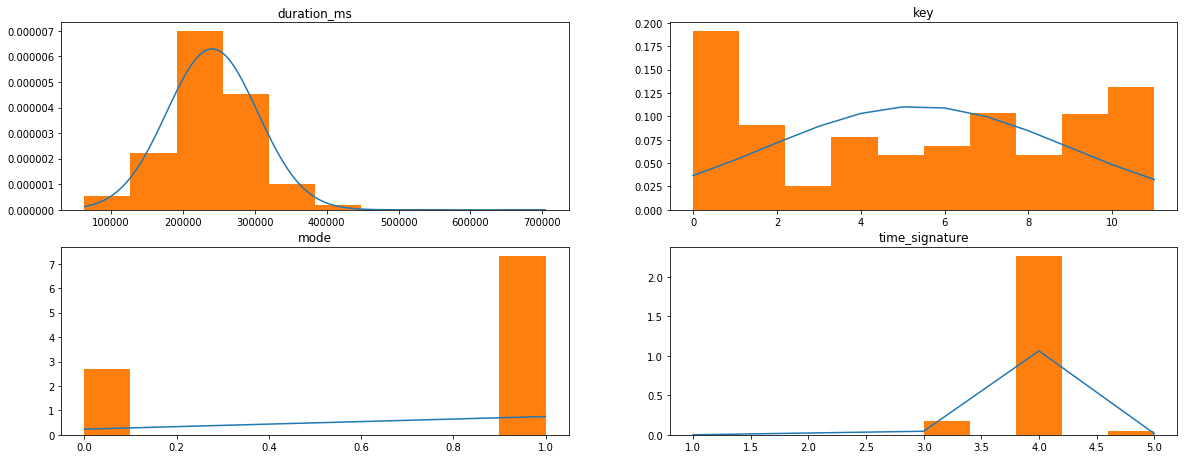

In [152]:
plt.figure(figsize=(20,20))
for idx, column in enumerate(data[['duration_ms','key','mode','time_signature']]):
    h = sorted(data[column])  #sorted
    fit = stats.norm.pdf(h, np.mean(h), np.std(h))
    
    plt.subplot(5,2,idx+1)
    plt.plot(h,fit)
    plt.title(column)
    plt.hist(h,density=True) 

     #use this to draw histogram of your data
plt.show()

In [153]:
data[['duration_ms','key','mode', 'time_signature']].describe()

duration_ms          key         mode  time_signature
count    2276.000000  2276.000000  2276.000000     2276.000000
mean   240770.905975     5.357206     0.731107        3.927944
std     63407.770266     3.605039     0.443482        0.368056
min     63000.000000     0.000000     0.000000        1.000000
25%    202871.250000     2.000000     0.000000        4.000000
50%    238997.500000     6.000000     1.000000        4.000000
75%    275344.500000     9.000000     1.000000        4.000000
max    704453.000000    11.000000     1.000000        5.000000

Songs are 4 minutes long on average. Nothing new here, because even typical songs outside our dataset are 3-5 minutes long.

For key, integers map to pitches using standard Pitch Class notation: https://en.wikipedia.org/wiki/Pitch_class. C is the most used key. 

Mode refers to track modality. Most tracks fall under 1 (major tracks). 

Most tracks also use the typical time signature of 4 beats. 

Overall, there's nothing surprising when we look at the above features. These are the characteristics of most songs.

# Examining Popularity

In [154]:
artists_top = artists.sort_values(by=['popularity'], ascending=False)

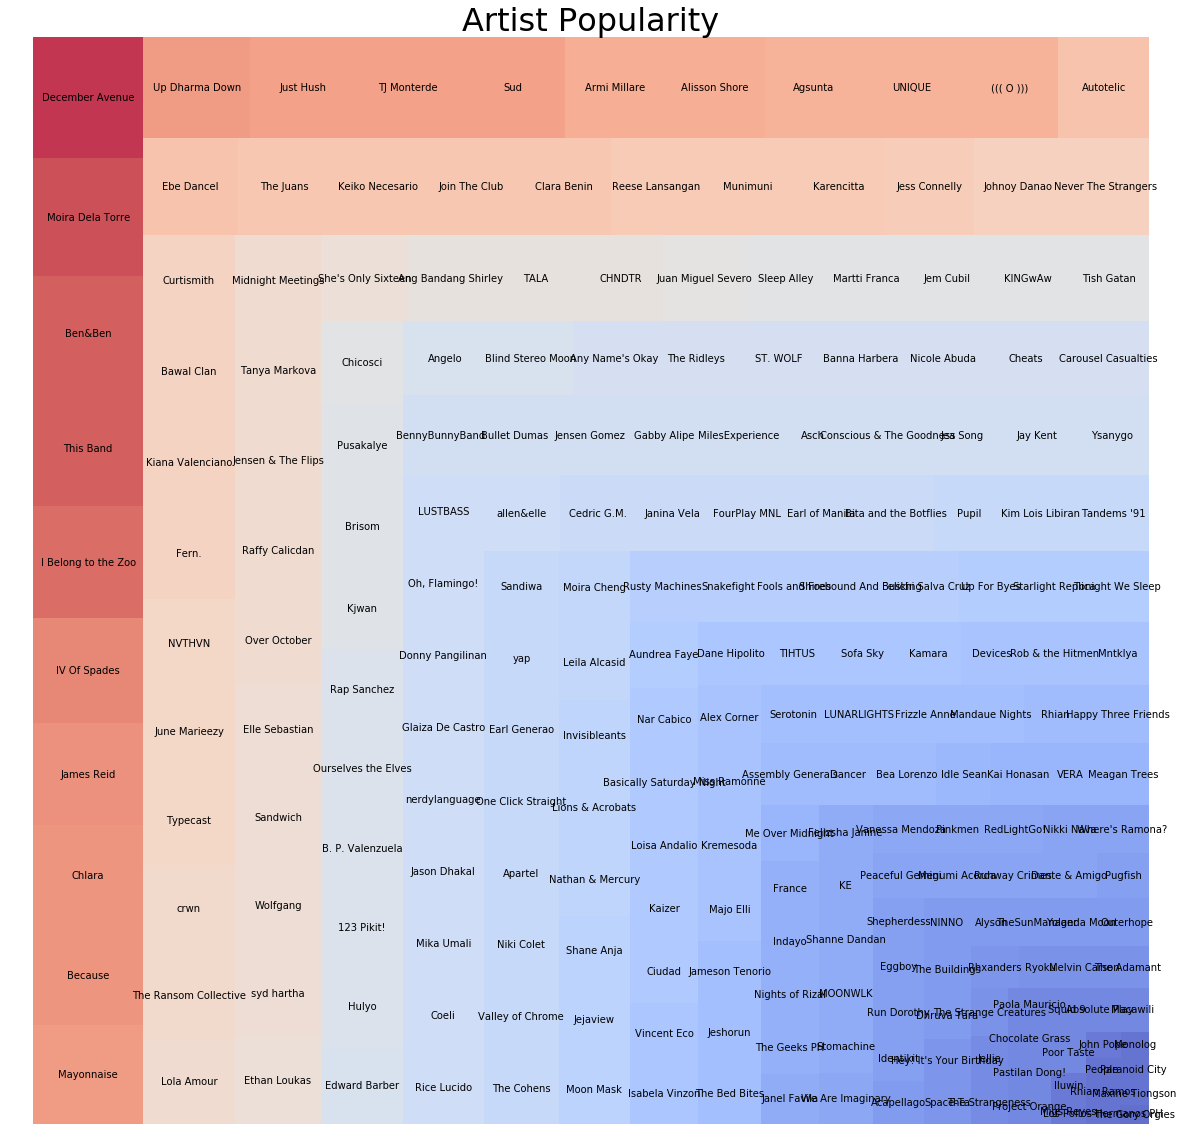

In [155]:
plt.figure(figsize=(20,20), facecolor='white')
cmap = matplotlib.cm.coolwarm
mini = min(artists_top["popularity"])
maxi = max(artists_top["popularity"])
# Finding Colors for each tile
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in artists_top["popularity"]]
# Plotting
squarify.plot(sizes=artists_top["popularity"], label=artists_top["artist_name"], alpha=0.8, color=colors)
# Removing Axis
plt.axis('off')
# Invert Y-Axis
plt.gca().invert_yaxis()
# Title
plt.title("Artist Popularity", fontsize=32)
# Title Positioning
ttl = ax.title
ttl.set_position([.5, 1.05])

There's no few artists dominating in terms of popularity. The values for popularity only decrease gradually.

In [156]:
artists_top['popularity %'] =( artists_top['popularity'] / sum(artists_top['popularity'])) *100

Text(0.5, 0, 'cumulative % of artist population')

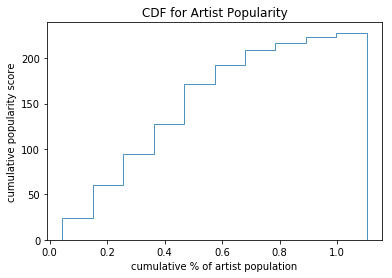

In [157]:
plt.hist(artists_top['popularity %'], cumulative=True, label='CDF', histtype='step', alpha=0.8)
plt.title("CDF for Artist Popularity")

plt.ylabel("cumulative popularity score")
plt.xlabel("cumulative % of artist population")

As you can see, the popularity distribution is almost linear. The most popular artists don't really take up a large chunk of the pupularity. The least popular ones, however, have very little popularity to go around.

In [158]:
artists_ranked = (artists.sort_values(by=['popularity'], ascending=False).head(10).artist_name).tolist()

popular = pd.DataFrame()
for artist in artists_ranked:
    popular = popular.append(data[data.artist_name == artist ])


In [159]:
Y_nosample = data[~data['artist_name'].isin(artists_ranked)]

In [160]:
col = ['acousticness','danceability','energy','instrumentalness','speechiness','valence','loudness','tempo']
Y_nosample = Y_nosample[col]

In [161]:
Y_sample = popular[col]

What are the popular songs like? Do they differ from the rest of the indie tracks?

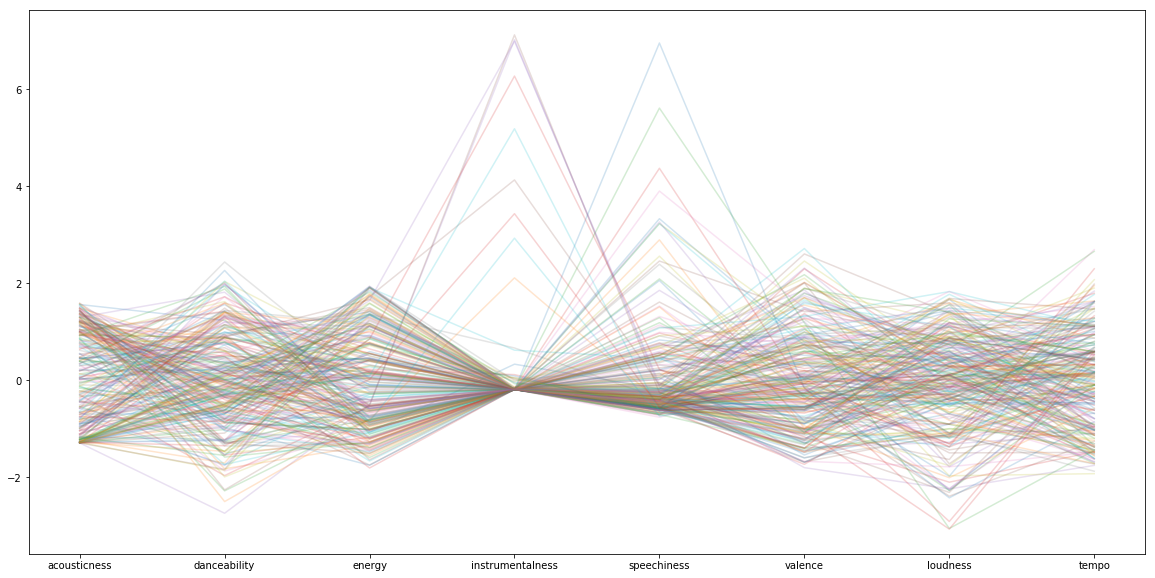

In [162]:
scaler = StandardScaler()
Y_sample = pd.DataFrame(scaler.fit_transform(Y_sample), columns = col)
Y_nosample = pd.DataFrame(scaler.fit_transform(Y_nosample), columns = col)

plt.figure(figsize=(20,10))
line = plt.plot(Y_sample.columns, Y_sample.T,alpha=0.2)

In [163]:
Y_sample.describe()

acousticness  danceability        energy  instrumentalness  \
count  2.670000e+02  2.670000e+02  2.670000e+02      2.670000e+02   
mean   1.368028e-16  2.449144e-16 -1.074879e-16     -2.502160e-16   
std    1.001878e+00  1.001878e+00  1.001878e+00      1.001878e+00   
min   -1.296635e+00 -2.746519e+00 -1.812536e+00     -1.936625e-01   
25%   -1.035710e+00 -6.572484e-01 -8.293050e-01     -1.936625e-01   
50%    2.093113e-02 -5.457424e-02 -1.128910e-01     -1.936531e-01   
75%    9.932164e-01  7.824732e-01  8.157159e-01     -1.932107e-01   
max    1.586886e+00  2.436479e+00  1.937608e+00      7.121667e+00   

        speechiness       valence      loudness         tempo  
count  2.670000e+02  2.670000e+02  2.670000e+02  2.670000e+02  
mean  -2.856641e-16 -3.991813e-17 -4.948185e-17  1.272390e-16  
std    1.001878e+00  1.001878e+00  1.001878e+00  1.001878e+00  
min   -7.653709e-01 -1.805524e+00 -3.073379e+00 -1.930075e+00  
25%   -5.237026e-01 -7.797601e-01 -5.033648e-01 -9.124057e-01  
50%   -3.558774e-01 -1.207229e-01  9.183611e-02  7.043867e-02  
75%    1.207461e-01  7.280004e-01  7.474268e-01  6.676320e-01  
max    6.954588e+00  2.714840e+00  1.828372e+00  2.691138e+00

Use a t-test to check for a meaningful difference between the popular songs and the rest of the tracks.

Null hypothesis: There is no significant difference between tracks of popular artist and the rest of the population

critical value = 0.1

In [164]:
stats.ttest_ind(Y_nosample,Y_sample,equal_var = False)

Ttest_indResult(statistic=array([-2.17317835e-15,  9.59980630e-15, -3.77484631e-15, -2.93000266e-16,
        1.63142223e-15,  2.57604737e-15,  2.07531281e-15, -1.82700105e-15]), pvalue=array([1., 1., 1., 1., 1., 1., 1., 1.]))

We accept the null hypothesis.

There is no significant difference between tracks of 10 most popular musicians and the rest for all features.

What about the popular songs of the artists?

In [165]:
top_tracks.sort_values(by=['popularity'], ascending=False).head().T

813   \
artist_id                                    7tKpXx21KVUOR6vvDs6xtg   
external_url      https://open.spotify.com/track/1X4l4i472kW5ofF...   
id                                           1X4l4i472kW5ofFP8Xo0x0   
image_300         https://i.scdn.co/image/84a3e19ef4dd270946c501...   
image_64          https://i.scdn.co/image/cf16e1eaa5b71b70c2c740...   
image_640         https://i.scdn.co/image/a311c46653a6db396e2f9a...   
name                                                           Sana   
popularity                                                       72   
preview_url       https://p.scdn.co/mp3-preview/2b67ae5b1d2b0e73...   
artist_name                                     I Belong to the Zoo   
album_name                                                     Sana   
release_date                                                   2018   
acousticness                                                  0.701   
danceability                                                   0.66   
duration_ms                                                  277099   
energy                                                        0.373   
instrumentalness                                                  0   
key                                                               7   
loudness                                                     -7.874   
mode                                                              1   
speechiness                                                   0.029   
tempo                                                       126.887   
time_signature                                                    4   
valence                                                       0.348   

                                                               434   \
artist_id                                    5HIZU0JzM0AgfItVOm4E08   
external_url      https://open.spotify.com/track/2RgD3eO4IIGF16r...   
id                                           2RgD3eO4IIGF16rR8Ch8OV   
image_300         https://i.scdn.co/image/d8f99dd0b487ce372980da...   
image_64          https://i.scdn.co/image/407c122530dcc204370900...   
image_640         https://i.scdn.co/image/c0518e66609d54afdc189a...   
name                                                   Hindi Na Nga   
popularity                                                       72   
preview_url       https://p.scdn.co/mp3-preview/cd1f1284fe0e33bb...   
artist_name                                               This Band   
album_name                                             Hindi Na Nga   
release_date                                                   2018   
acousticness                                                 0.0877   
danceability                                                  0.396   
duration_ms                                                  282442   
energy                                                        0.413   
instrumentalness                                           2.95e-05   
key                                                               7   
loudness                                                    -11.566   
mode                                                              1   
speechiness                                                  0.0334   
tempo                                                       136.818   
time_signature                                                    4   
valence                                                       0.108   

                                                               1248  \
artist_id                                    4DAcJXcjX0zlQAZAPAx4Zb   
external_url      https://open.spotify.com/track/1yDiru08Q6omDOG...   
id                                           1yDiru08Q6omDOGkZMPnei   
image_300         https://i.scdn.co/image/e9427f75f16380a9447a64...   
image_64          https://i.scdn.co/image/71564475399ac06f3b9d03...   
image_640         https://i.scdn.co/image/dab6485cfa82f28b2718f3...   
name          

In [235]:
top_tracks.sort_values(by=['popularity'], ascending=False)[["name","artist_name"]].head(10)

name          artist_name
813                                                Sana  I Belong to the Zoo
434                                        Hindi Na Nga            This Band
1248                                    Maybe The Night              Ben&Ben
1152                             Kung 'Di Rin Lang Ikaw      December Avenue
1154  Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...      December Avenue
435                                    Kahit Ayaw Mo Na            This Band
436                                      'Di Na Babalik            This Band
1153                                              Dahan      December Avenue
1155                                             Bulong      December Avenue
814                                         Balang Araw  I Belong to the Zoo

In [166]:
top_nine = top_tracks[top_tracks['popularity'] >= 70].sort_values(by=['popularity'], ascending=False)

Spotify measures track popularity based on the total number of plays and how recent those plays are. 

For now, let's look at the 9 most popular tracks. 

In [167]:
top_nine['popularity']

434     72.0
813     72.0
1152    71.0
1248    71.0
435     70.0
436     70.0
1153    70.0
1154    70.0
1155    70.0
Name: popularity, dtype: float64

In [168]:
top_nine.iloc[0]

artist_id                                      5HIZU0JzM0AgfItVOm4E08
external_url        https://open.spotify.com/track/2RgD3eO4IIGF16r...
id                                             2RgD3eO4IIGF16rR8Ch8OV
image_300           https://i.scdn.co/image/d8f99dd0b487ce372980da...
image_64            https://i.scdn.co/image/407c122530dcc204370900...
image_640           https://i.scdn.co/image/c0518e66609d54afdc189a...
name                                                     Hindi Na Nga
popularity                                                         72
preview_url         https://p.scdn.co/mp3-preview/cd1f1284fe0e33bb...
artist_name                                                 This Band
album_name                                               Hindi Na Nga
release_date                                                     2018
acousticness                                                   0.0877
danceability                                                    0.396
duration_ms         

Hindi Na Nga by This Band is a pop "hugot" song.

In [169]:
top_nine.iloc[1]

artist_id                                      7tKpXx21KVUOR6vvDs6xtg
external_url        https://open.spotify.com/track/1X4l4i472kW5ofF...
id                                             1X4l4i472kW5ofFP8Xo0x0
image_300           https://i.scdn.co/image/84a3e19ef4dd270946c501...
image_64            https://i.scdn.co/image/cf16e1eaa5b71b70c2c740...
image_640           https://i.scdn.co/image/a311c46653a6db396e2f9a...
name                                                             Sana
popularity                                                         72
preview_url         https://p.scdn.co/mp3-preview/2b67ae5b1d2b0e73...
artist_name                                       I Belong to the Zoo
album_name                                                       Sana
release_date                                                     2018
acousticness                                                    0.701
danceability                                                     0.66
duration_ms         

Sana by I Belong to the Zoo is an acoustic pop song with lyrics also about heartbreak.

In [170]:
top_nine.iloc[2]

artist_id                                      4qFxP3qN9GsnZDOkAE6x2m
external_url        https://open.spotify.com/track/2BgD4nRyx9EZ5o8...
id                                             2BgD4nRyx9EZ5o8YEnjRSV
image_300           https://i.scdn.co/image/eb376b5b1d3c4727ff4586...
image_64            https://i.scdn.co/image/7510ece15fedaded0a5596...
image_640           https://i.scdn.co/image/6e0fcdfaf773fb8ce47b4b...
name                                           Kung 'Di Rin Lang Ikaw
popularity                                                         71
preview_url         https://p.scdn.co/mp3-preview/19ae661dea5372b7...
artist_name                                           December Avenue
album_name                                     Kung 'Di Rin Lang Ikaw
release_date                                                     2018
acousticness                                                    0.161
danceability                                                    0.502
duration_ms         

 Kung 'Di Rin Lang Ikaw by December Avenue yet another song about heartbreak.

In [171]:
top_nine.iloc[3]

artist_id                                      4DAcJXcjX0zlQAZAPAx4Zb
external_url        https://open.spotify.com/track/1yDiru08Q6omDOG...
id                                             1yDiru08Q6omDOGkZMPnei
image_300           https://i.scdn.co/image/e9427f75f16380a9447a64...
image_64            https://i.scdn.co/image/71564475399ac06f3b9d03...
image_640           https://i.scdn.co/image/dab6485cfa82f28b2718f3...
name                                                  Maybe The Night
popularity                                                         71
preview_url         https://p.scdn.co/mp3-preview/1c14ab24c9add31f...
artist_name                                                   Ben&Ben
album_name                                            Maybe The Night
release_date                                                     2017
acousticness                                                    0.113
danceability                                                    0.572
duration_ms         

Maybe The Night by Ben&Ben is a love song that was used in the film Exes Baggage and a CloseUp ad, which likely aided its popularity.

In [172]:
top_nine.iloc[4]

artist_id                                      5HIZU0JzM0AgfItVOm4E08
external_url        https://open.spotify.com/track/58grXgbCj7t5ulr...
id                                             58grXgbCj7t5ulr0TGLIr9
image_300           https://i.scdn.co/image/db450749480c5d35a85b4b...
image_64            https://i.scdn.co/image/df8157af631d344eaa6bc7...
image_640           https://i.scdn.co/image/6a1f6f99e8ba9f98d3538f...
name                                                 Kahit Ayaw Mo Na
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/1dbe606aa34cd8fa...
artist_name                                                 This Band
album_name                                           Kahit Ayaw Mo Na
release_date                                                     2018
acousticness                                                    0.341
danceability                                                    0.662
duration_ms         

Kahit Ayaw Mo Na is another song by This Band. It's thematically similar to Hindi Na Nga.

In [173]:
top_nine.iloc[5]

artist_id                                      5HIZU0JzM0AgfItVOm4E08
external_url        https://open.spotify.com/track/7hoP5NDUXEbmOaw...
id                                             7hoP5NDUXEbmOawvEAsi8h
image_300           https://i.scdn.co/image/179fb42ff7584a3e5619ac...
image_64            https://i.scdn.co/image/f7108f50ee31b4c5badc41...
image_640           https://i.scdn.co/image/ef2627919d10458fc2d152...
name                                                   'Di Na Babalik
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/26eb4bba8d4e97b7...
artist_name                                                 This Band
album_name                                             'Di Na Babalik
release_date                                                     2019
acousticness                                                  0.00819
danceability                                                    0.358
duration_ms         

'Di Na Babalik is yet another song of heartbreak by This Band. 

In [174]:
top_nine.iloc[6]

artist_id                                      4qFxP3qN9GsnZDOkAE6x2m
external_url        https://open.spotify.com/track/6BxJLJw228OY5BF...
id                                             6BxJLJw228OY5BFerPGl7z
image_300           https://i.scdn.co/image/9f67bee339fb7781cb1e52...
image_64            https://i.scdn.co/image/7e7ac1b30d14fd2ae35066...
image_640           https://i.scdn.co/image/d8845b013badbe791f5211...
name                                                            Dahan
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/cc1d02233bdf4426...
artist_name                                           December Avenue
album_name                                                      Dahan
release_date                                                     2019
acousticness                                                    0.318
danceability                                                    0.516
duration_ms         

Dahan by December Avenue is another "hugot" song about letting go.

In [175]:
top_nine.iloc[7]

artist_id                                      4qFxP3qN9GsnZDOkAE6x2m
external_url        https://open.spotify.com/track/24ngpWhBOxKJtIP...
id                                             24ngpWhBOxKJtIPnzSNX8c
image_300           https://i.scdn.co/image/120f1fa2f821eac040ab20...
image_64            https://i.scdn.co/image/d0541fb7a1f93f49883474...
image_640           https://i.scdn.co/image/a7b42a7b13dd0bb7db5b13...
name                Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/861fcd85dfd44d31...
artist_name                                           December Avenue
album_name          Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...
release_date                                                     2019
acousticness                                                   0.0208
danceability                                                    0.465
duration_ms         

Huling Sandali by December Avenue is part of the movie soundtrack for Tayo Sa Huling Buwan Ng Taon. It also counts as a feelsy hugot song.

In [176]:
top_nine.iloc[8]

artist_id                                      4qFxP3qN9GsnZDOkAE6x2m
external_url        https://open.spotify.com/track/5nMKJJ5Rl6X1yn5...
id                                             5nMKJJ5Rl6X1yn58aVeICO
image_300           https://i.scdn.co/image/7349e39d4af38680426f55...
image_64            https://i.scdn.co/image/a127d1cc34a9a48b1cff29...
image_640           https://i.scdn.co/image/18e1d5d00272c0c017f9e2...
name                                                           Bulong
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/5d790300eeab3fed...
artist_name                                           December Avenue
album_name                                                     Bulong
release_date                                                     2018
acousticness                                                   0.0319
danceability                                                      0.5
duration_ms         

Bulong by December Avenue is about longing.

Hugot* count: 8/9 

I'm sensing a pattern here. Of course, it could be that most songs are produced are just hugot songs. To find out, we'll have to first classify whether a song was a hugot song or not, and then see if there is a statistically significant difference in terms of popularity for hugot and non-hugot songs. This topic can be explored in a different project since there are too many songs to manually classify (about 2,600) and not enough time. 


*Hugot songs are defined here as songs about heartbreak. It can take various forms: breaking up with someone, unrequited love, star-crossed lovers, etc. so long as that element of failed romance is involved.

In [177]:
top_nine_features = top_nine[['acousticness','danceability','energy','instrumentalness',
                              'loudness','speechiness','tempo','valence','mode','key','time_signature']]

top_nine_features.describe()

acousticness  danceability    energy  instrumentalness   loudness  \
count      9.000000      9.000000  9.000000          9.000000   9.000000   
mean       0.198066      0.514556  0.511444          0.000136  -7.338667   
std        0.224620      0.104634  0.105879          0.000307   2.219810   
min        0.008190      0.358000  0.373000          0.000000 -11.566000   
25%        0.031900      0.465000  0.435000          0.000000  -8.539000   
50%        0.113000      0.502000  0.522000          0.000002  -7.265000   
75%        0.318000      0.572000  0.529000          0.000049  -5.472000   
max        0.701000      0.662000  0.728000          0.000936  -4.736000   

       speechiness       tempo   valence      mode        key  time_signature  
count     9.000000    9.000000  9.000000  9.000000   9.000000             9.0  
mean      0.031578  120.009111  0.268111  0.888889   6.111111             4.0  
std       0.003660   25.816959  0.147705  0.333333   3.218868             0.0  
min       0.025700   74.050000  0.108000  0.000000   2.000000             4.0  
25%       0.029000  126.887000  0.132000  1.000000   4.000000             4.0  
50%       0.031300  129.973000  0.295000  1.000000   7.000000             4.0  
75%       0.034900  134.877000  0.351000  1.000000   9.000000             4.0  
max       0.036700  139.867000  0.498000  1.000000  10.000000             4.0

In [178]:
top_track_cluster = pd.DataFrame()

for idx in range(9):
    top_track_cluster = top_track_cluster.append(clustered_data[clustered_data['id']== top_nine['id'].iloc[idx]])

top_track_cluster

acousticness  danceability  energy  instrumentalness  speechiness  \
993        0.08770         0.396   0.413          0.000029       0.0334   
1693       0.70100         0.660   0.373          0.000000       0.0290   
211        0.16100         0.502   0.482          0.000000       0.0288   
2490       0.11300         0.572   0.522          0.000049       0.0367   
992        0.34100         0.662   0.529          0.000208       0.0351   
987        0.00819         0.358   0.435          0.000936       0.0349   
205        0.31800         0.516   0.529          0.000000       0.0257   
204        0.02080         0.465   0.592          0.000002       0.0293   
212        0.03190         0.500   0.728          0.000000       0.0313   

      valence  loudness    tempo  cluster                      id  \
993     0.108   -11.566  136.818        1  2RgD3eO4IIGF16rR8Ch8OV   
1693    0.348    -7.874  126.887        1  1X4l4i472kW5ofFP8Xo0x0   
211     0.132    -4.736  133.894        0  2BgD4nRyx9EZ5o8YEnjRSV   
2490    0.498    -9.095   74.050        2  1yDiru08Q6omDOGkZMPnei   
992     0.424    -8.539  127.584        2  58grXgbCj7t5ulr0TGLIr9   
987     0.140    -7.265   76.132        0  7hoP5NDUXEbmOawvEAsi8h   
205     0.295    -6.596  129.973        0  6BxJLJw228OY5BFerPGl7z   
204     0.117    -4.905  139.867        0  24ngpWhBOxKJtIPnzSNX8c   
212     0.351    -5.472  134.877        0  5nMKJJ5Rl6X1yn58aVeICO   

                                                   name          artist_name  
993                                        Hindi Na Nga            This Band  
1693                                               Sana  I Belong to the Zoo  
211                              Kung 'Di Rin Lang Ikaw      December Avenue  
2490                                    Maybe The Night              Ben&Ben  
992                                    Kahit Ayaw Mo Na            This Band  
987                                      'Di Na Babalik            This Band  
205                                               Dahan      December Avenue  
204   Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...      December Avenue  
212                                              Bulong      December Avenue

The spread of clusters is varied enough.

In [179]:
top_track_mood = pd.DataFrame()

for idx in range(9):
    top_track_mood = top_track_mood.append(mood_cluster[mood_cluster['id']== top_nine['id'].iloc[idx]])

top_track_mood

danceability  valence  energy    tempo  cluster  \
993          0.396    0.108   0.413  136.818        1   
1693         0.660    0.348   0.373  126.887        1   
211          0.502    0.132   0.482  133.894        1   
2490         0.572    0.498   0.522   74.050        2   
992          0.662    0.424   0.529  127.584        2   
987          0.358    0.140   0.435   76.132        1   
205          0.516    0.295   0.529  129.973        0   
204          0.465    0.117   0.592  139.867        0   
212          0.500    0.351   0.728  134.877        0   

                                                   name          artist_name  \
993                                        Hindi Na Nga            This Band   
1693                                               Sana  I Belong to the Zoo   
211                              Kung 'Di Rin Lang Ikaw      December Avenue   
2490                                    Maybe The Night              Ben&Ben   
992                                    Kahit Ayaw Mo Na            This Band   
987                                      'Di Na Babalik            This Band   
205                                               Dahan      December Avenue   
204   Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...      December Avenue   
212                                              Bulong      December Avenue   

                          id  
993   2RgD3eO4IIGF16rR8Ch8OV  
1693  1X4l4i472kW5ofFP8Xo0x0  
211   2BgD4nRyx9EZ5o8YEnjRSV  
2490  1yDiru08Q6omDOGkZMPnei  
992   58grXgbCj7t5ulr0TGLIr9  
987   7hoP5NDUXEbmOawvEAsi8h  
205   6BxJLJw228OY5BFerPGl7z  
204   24ngpWhBOxKJtIPnzSNX8c  
212   5nMKJJ5Rl6X1yn58aVeICO

Same with the mood clustering.

In [180]:
top_track_properties = pd.DataFrame()

for idx in range(9):
    top_track_properties = top_track_properties.append(properties_cluster[properties_cluster['id']== top_nine['id'].iloc[idx]])

top_track_properties

loudness  speechiness  instrumentalness  cluster  \
993    -11.566       0.0334          0.000029        0   
1693    -7.874       0.0290          0.000000        0   
211     -4.736       0.0288          0.000000        0   
2490    -9.095       0.0367          0.000049        0   
992     -8.539       0.0351          0.000208        0   
987     -7.265       0.0349          0.000936        0   
205     -6.596       0.0257          0.000000        0   
204     -4.905       0.0293          0.000002        0   
212     -5.472       0.0313          0.000000        0   

                                                   name          artist_name  \
993                                        Hindi Na Nga            This Band   
1693                                               Sana  I Belong to the Zoo   
211                              Kung 'Di Rin Lang Ikaw      December Avenue   
2490                                    Maybe The Night              Ben&Ben   
992                                    Kahit Ayaw Mo Na            This Band   
987                                      'Di Na Babalik            This Band   
205                                               Dahan      December Avenue   
204   Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...      December Avenue   
212                                              Bulong      December Avenue   

                          id  
993   2RgD3eO4IIGF16rR8Ch8OV  
1693  1X4l4i472kW5ofFP8Xo0x0  
211   2BgD4nRyx9EZ5o8YEnjRSV  
2490  1yDiru08Q6omDOGkZMPnei  
992   58grXgbCj7t5ulr0TGLIr9  
987   7hoP5NDUXEbmOawvEAsi8h  
205   6BxJLJw228OY5BFerPGl7z  
204   24ngpWhBOxKJtIPnzSNX8c  
212   5nMKJJ5Rl6X1yn58aVeICO

For properties, they're all grouped under one cluster.


Let's look at the other popular songs.

In [181]:
top_60 = top_tracks[(top_tracks['popularity'] < 70) & (top_tracks['popularity'] >= 60)].sort_values(by=['popularity'], ascending=False)

In [182]:
top_60_cluster = pd.DataFrame()

for idx in range(9):
    top_60_cluster = top_60_cluster.append(clustered_data[clustered_data['id']== top_60['id'].iloc[idx]])

top_60_cluster

acousticness  danceability  energy  instrumentalness  speechiness  \
1692        0.3950         0.523   0.391          0.000000       0.0298   
2491        0.7760         0.491   0.314          0.000005       0.0301   
2469        0.5060         0.669   0.420          0.000000       0.0253   
215         0.0846         0.518   0.761          0.000000       0.0302   
777         0.3070         0.374   0.536          0.000000       0.0267   
1678        0.1760         0.705   0.401          0.000009       0.0376   
214         0.1320         0.450   0.648          0.000024       0.0308   
1702        0.8620         0.566   0.121          0.000000       0.0345   
1709        0.8870         0.445   0.355          0.001790       0.0289   

      valence  loudness    tempo  cluster                      id  \
1692    0.354    -9.283  139.905        1  5NXdUJ3Z2jhlp2u1cj6f7m   
2491    0.295    -8.580  126.921        1  3WUEs51GpcvlgU7lehLgLh   
2469    0.523    -8.464   95.049        2  5l9g7py8RCblcvbZgGQgSd   
215     0.282    -3.905  155.981        0  00mBzIWv5gHOYxwuEJXjOG   
777     0.508    -5.966  161.681        0  3vGkyQlCw8LklNip0ZUELC   
1678    0.481    -8.900  140.031        2  4u8RkgV6P4TLi89SmlUtv8   
214     0.282    -4.516  144.814        0  6GIzDc4xBUeYHwubWwTrhC   
1702    0.293    -8.206  135.268        1  0ztDBQdQmdVZvorSmIjMih   
1709    0.366    -7.351  135.525        1  0gDRtumoR9ZrvAlnniToMz   

                       name          artist_name  
1692            Balang Araw  I Belong to the Zoo  
2491           Kathang Isip              Ben&Ben  
2469              Pagtingin              Ben&Ben  
215   Sa Ngalan Ng Pag-Ibig      December Avenue  
777                  Nobela        Join The Club  
1678                  Mundo         IV Of Spades  
214        Kahit Di Mo Alam      December Avenue  
1702                Tagpuan     Moira Dela Torre  
1709            Ikaw At Ako     Moira Dela Torre

In [183]:
top_60_cluster = pd.DataFrame()

for idx in range(9):
    top_60_cluster = top_60_cluster.append(mood_cluster[mood_cluster['id']== top_60['id'].iloc[idx]])

top_60_cluster

danceability  valence  energy    tempo  cluster                   name  \
1692         0.523    0.354   0.391  139.905        1            Balang Araw   
2491         0.491    0.295   0.314  126.921        1           Kathang Isip   
2469         0.669    0.523   0.420   95.049        2              Pagtingin   
215          0.518    0.282   0.761  155.981        0  Sa Ngalan Ng Pag-Ibig   
777          0.374    0.508   0.536  161.681        0                 Nobela   
1678         0.705    0.481   0.401  140.031        2                  Mundo   
214          0.450    0.282   0.648  144.814        0       Kahit Di Mo Alam   
1702         0.566    0.293   0.121  135.268        1                Tagpuan   
1709         0.445    0.366   0.355  135.525        1            Ikaw At Ako   

              artist_name                      id  
1692  I Belong to the Zoo  5NXdUJ3Z2jhlp2u1cj6f7m  
2491              Ben&Ben  3WUEs51GpcvlgU7lehLgLh  
2469              Ben&Ben  5l9g7py8RCblcvbZgGQgSd  
215       December Avenue  00mBzIWv5gHOYxwuEJXjOG  
777         Join The Club  3vGkyQlCw8LklNip0ZUELC  
1678         IV Of Spades  4u8RkgV6P4TLi89SmlUtv8  
214       December Avenue  6GIzDc4xBUeYHwubWwTrhC  
1702     Moira Dela Torre  0ztDBQdQmdVZvorSmIjMih  
1709     Moira Dela Torre  0gDRtumoR9ZrvAlnniToMz

In [184]:
top_60_cluster = pd.DataFrame()

for idx in range(9):
    top_60_cluster = top_60_cluster.append(properties_cluster[properties_cluster['id']== top_60['id'].iloc[idx]])

top_60_cluster

loudness  speechiness  instrumentalness  cluster                   name  \
1692    -9.283       0.0298          0.000000        0            Balang Araw   
2491    -8.580       0.0301          0.000005        0           Kathang Isip   
2469    -8.464       0.0253          0.000000        0              Pagtingin   
215     -3.905       0.0302          0.000000        0  Sa Ngalan Ng Pag-Ibig   
777     -5.966       0.0267          0.000000        0                 Nobela   
1678    -8.900       0.0376          0.000009        0                  Mundo   
214     -4.516       0.0308          0.000024        0       Kahit Di Mo Alam   
1702    -8.206       0.0345          0.000000        0                Tagpuan   
1709    -7.351       0.0289          0.001790        0            Ikaw At Ako   

              artist_name                      id  
1692  I Belong to the Zoo  5NXdUJ3Z2jhlp2u1cj6f7m  
2491              Ben&Ben  3WUEs51GpcvlgU7lehLgLh  
2469              Ben&Ben  5l9g7py8RCblcvbZgGQgSd  
215       December Avenue  00mBzIWv5gHOYxwuEJXjOG  
777         Join The Club  3vGkyQlCw8LklNip0ZUELC  
1678         IV Of Spades  4u8RkgV6P4TLi89SmlUtv8  
214       December Avenue  6GIzDc4xBUeYHwubWwTrhC  
1702     Moira Dela Torre  0ztDBQdQmdVZvorSmIjMih  
1709     Moira Dela Torre  0gDRtumoR9ZrvAlnniToMz

The next batch of popular songs fall under the one cluster.

Is there a connection between song popularity and its cluster?

In [185]:
top_tracks_clustered = top_tracks.merge(clustered_data[['cluster','id']], on='id')

In [186]:
top_tracks_clustered = top_tracks_clustered.sort_values(by=['popularity'], ascending=False)

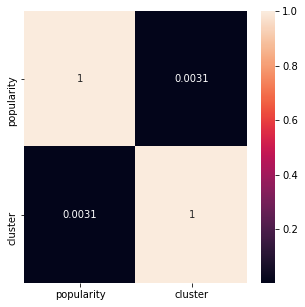

In [187]:
plt.figure(figsize=(5, 5))
corr = top_tracks_clustered[['popularity','cluster']].corr()
sns.heatmap(corr, 
            xticklabels=top_tracks_clustered[['popularity','cluster']].columns.values,
            yticklabels=top_tracks_clustered[['popularity','cluster']].columns.values,
            annot=True)

Looks like popularity and cluster have little correlation. It could just be that most songs fall under the second cluster.

In [188]:
top_tracks_clustered[['cluster','popularity']].groupby('cluster').describe()

popularity                                                   
             count       mean        std  min   25%   50%   75%   max
cluster                                                              
0            435.0  18.988506  15.223598  0.0   7.0  16.0  27.5  71.0
1            428.0  25.021028  16.935946  0.0  10.0  24.0  38.0  72.0
2            428.0  19.079439  15.788065  0.0   5.0  16.0  30.0  71.0

Yep, this is the case. The clustering count isn't vastly uneven, each cluster has a popular song, and the popularity means are close to each other.

Maybe we can find something with the properties clustering.

In [189]:
top_tracks_properties = top_tracks.merge(properties_cluster[['cluster','id']], on='id')
top_tracks_properties.columns

Index(['artist_id', 'external_url', 'id', 'image_300', 'image_64', 'image_640',
       'name', 'popularity', 'preview_url', 'artist_name', 'album_name',
       'release_date', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence', 'cluster'],
      dtype='object')

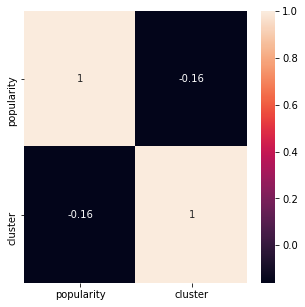

In [190]:
plt.figure(figsize=(5, 5))
corr = top_tracks_properties[['popularity','cluster']].corr()
sns.heatmap(corr, 
            xticklabels=top_tracks_properties[['popularity','cluster']].columns.values,
            yticklabels=top_tracks_properties[['popularity','cluster']].columns.values,
            annot=True)

No correlation, it looks like. 

In [191]:
top_tracks_properties[['cluster','popularity']].groupby('cluster').describe()

popularity                                                  
             count       mean        std  min  25%   50%   75%   max
cluster                                                             
0           1034.0  22.499033  16.313735  0.0  9.0  20.0  33.0  72.0
1            179.0  14.424581  14.513019  0.0  2.0   8.0  24.0  59.0
2             78.0  16.525641  14.286243  0.0  5.0  10.5  27.0  51.0

Are the popularity differences in each cluster statistically significant?

Our critical value is 0.05

In [192]:
properties_0 = top_tracks_properties['popularity'][top_tracks_properties['cluster']==0]
properties_1 = top_tracks_properties['popularity'][top_tracks_properties['cluster']==1]
properties_2 = top_tracks_properties['popularity'][top_tracks_properties['cluster']==2]

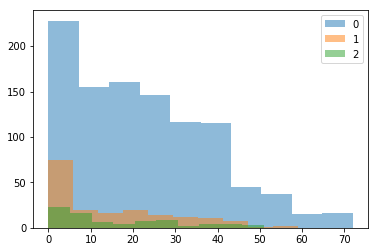

In [193]:
plt.hist(properties_0, label='0', alpha=0.5) 
plt.hist(properties_1, label='1', alpha=0.5)
plt.hist(properties_2, label='2', alpha=0.5) 
plt.legend()

To perform one way ANOVA, the population must usually be normally distributed in each group.

However, violations of normality are not usually a death sentence for validity. As long as the sample size exceeds 30 (even better if it is greater than 50), there is not usually too much of an impact to validity from non-normal data; something that Stevens stressed in his 2016 publication of Applied Multivariate Statistics for the Social Sciences.

In [194]:
#Let's test for homogeneity of variance
stats.levene(properties_0,properties_1,properties_2)

LeveneResult(statistic=2.19445794173214, pvalue=0.11183535227168524)

We accept the null hypothesis that the variances are equal. 

In [195]:
stats.f_oneway(properties_0,properties_1,properties_2)

F_onewayResult(statistic=22.813604203412964, pvalue=1.8349816435271089e-10)

Looks like there's no statistically significant difference.

# Album Variation

Album variation will be measured based on how different its feature values are from all the other albums.

What we want to do is measure how each track deviates in distance from all the other tracks in the album.

To do this, we first perform PCA on the data then calculate the standard deviation per album. This will serve as the album track variation score.

In [196]:
reduced_data = pd.DataFrame(reduced_data)
reduced_data['id'] = data['id'].values
reduced_data['name'] = data['name'].values
reduced_data['artist_name'] = data['artist_name'].values
reduced_data['album_id'] = data['album_id'].values
reduced_data['album_name'] = data['album_name'].values
reduced_data['album_type'] = data['album_type'].values
reduced_data.head()

0         1                      id  \
0  2.728120  0.077825  3kFDnFj6asUJsUPodsWT2o   
1  0.290615 -0.897332  1I4FVXxMHTy07BvPO1mVjA   
2  2.284328 -0.011178  2IFNR24j14O8IuqLxFr0NT   
3  1.734308 -0.872133  4FrzR2A8kmSKB87Nx2oZjR   
4 -1.158518  1.114388  2vqAmth0yZZbBxwmVdE9V2   

                                    name      artist_name  \
0  Away from the Current (Piano Version)  Keiko Necesario   
1                                 Blithe  Keiko Necesario   
2                      Let Me Be The One  Keiko Necesario   
3                            Ikaw Pa Rin  Keiko Necesario   
4                              Panaginip  Keiko Necesario   

                 album_id                                         album_name  \
0  7Lnn2od0JUFPDM6H9RXPBQ              Away from the Current (Piano Version)   
1  5ekL2fwFPglRj6BvLLU26A                                             Blithe   
2  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
3  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
4  6fRKrRev7RcNBXCm326IXw  Ang Babaeng Allergic Sa Wifi (Original Motion ...   

  album_type  
0     single  
1     single  
2     single  
3     single  
4     single

In [197]:
to_highlight = reduced_data[reduced_data['album_id']=='4acHD3ykZw3DYLcLW1Mqv3']

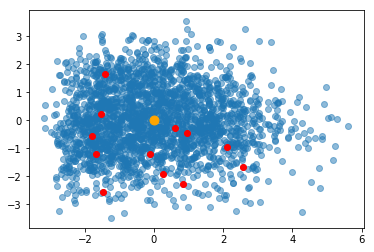

In [198]:
plt.scatter(reduced_data[0],reduced_data[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='red')
plt.scatter(reduced_data[0].mean(),reduced_data[1].mean(), color='orange', s=80)

In [199]:
#get rid of tracks that are singles
print(reduced_data.shape)
reduced_albums=reduced_data[reduced_data['album_type']=='album']
print(reduced_albums.shape)

(2276, 8)
(1166, 8)


In [200]:
#get the standard deviation per album
reduced_albums_std = reduced_albums.groupby('album_id').std().reset_index()
reduced_albums_std.head()

album_id         0         1
0  02txPZEr9smumnFaxOrdAt  1.416037  0.935363
1  05rQadwAVYTpNNnBoeTuj0  0.930931  1.215329
2  08nQUfuftB2KzgfTZNld8A  2.060924  1.144757
3  0A251v7CqF6LAx74bmqZks  1.004592  1.191143
4  0DWKo3p5bQSV3td2etejXJ  1.256164  1.006416

In [201]:
reduced_albums_std = reduced_albums[['album_id','artist_name','album_name']].drop_duplicates().merge(reduced_albums_std, on='album_id')
reduced_albums_std.head()

album_id       artist_name  \
0  4acHD3ykZw3DYLcLW1Mqv3        Ebe Dancel   
1  4bU263JJqschDhYZRgbnt7         Autotelic   
2  0oZlesVQj072lg8KM4ojFC          Sandwich   
3  46FVwz9NCaXlRWlBSx7LG4  B. P. Valenzuela   
4  2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   

                                        album_name         0         1  
0                                       Bawat Daan  1.526190  1.163761  
1                                  Papunta Pabalik  1.059590  0.603990  
2                                           Debris  0.753000  0.859348  
3                                        Neon Hour  0.699928  1.040265  
4  Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede  2.009814  0.757762

In [202]:
#get distance from the origin (0,0) since a standard deviation of 0 means all tracks are equal to the mean  
reduced_albums_std['album_distance'] =[euclidean([reduced_albums_std.loc[x][0],reduced_albums_std.loc[x][1]],[0,0]) for x in range(len(reduced_albums_std))]

In [203]:
reduced_albums_std.sort_values(by='album_distance').head(10) #Albums with the most similar tracks

album_id            artist_name  \
30   4cx6CRSKWfQ90pSIbptsQh       Lions & Acrobats   
33   2KzwyXW4u2MewGOnioHyT0                  Pupil   
108  0ab6fhMmKWtTfczaxprpiy            Rap Sanchez   
32   7fy9ViwHRwWAEmG4upZLn9                 Cheats   
53   3SrqGYBJ6MaJ7QZu8yTZSN             Curtismith   
84   7i8cfv0rwUaJ0Q1KTTl7IM      Assembly Generals   
11   3LWiguQVKE7gAP1PsAyrwv  The Ransom Collective   
64   7z2DVbUC9iLaBZe8mTmmE1        Nights of Rizal   
76   13vapJJUG4b1an7XNR56Hz             123 Pikit!   
56   0EPue1OBoRjRYpgQ3wLreE             James Reid   

                             album_name         0         1  album_distance  
30   Points & Perspectives (Remastered)  0.428973  0.428889        0.606600  
33                                Zilch  0.480758  0.584191        0.756576  
108                             Emprise  0.512599  0.558462        0.758049  
32                               Cheats  0.596173  0.493453        0.773898  
53                        Soully, Yours  0.647097  0.531286        0.837258  
84                              Fatigue  0.595828  0.603836        0.848310  
11                               Traces  0.694012  0.546688        0.883471  
64                          summer/salt  0.720868  0.560329        0.913028  
76                            Taeng Aso  0.477798  0.797920        0.930036  
56                          Palm Dreams  0.532442  0.791625        0.954025

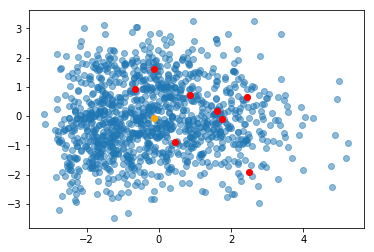

In [204]:
to_highlight = reduced_albums[reduced_albums['album_id']=='2mgoR6YKtUvawT9bAYwXjG']
plt.scatter(reduced_albums[0],reduced_albums[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='red')
plt.scatter(reduced_albums[0].mean(),reduced_albums[1].mean(), color='orange')

In [205]:
reduced_albums_std.sort_values(by='album_distance', ascending=False).head(10) #Albums with the least similar tracks

album_id       artist_name  \
75   1fhIqZTgAKsfEeNfzVHyZ6            lluwin   
97   4jZMhB0AgTzISkuSoy0nsd    Pastilan Dong!   
12   08nQUfuftB2KzgfTZNld8A   MilesExperience   
65   2tP8y1GDr7DNomBkcJI0H0           MOONWLK   
59   60qph1sDjhgZtPR4IEnu5Y            UNIQUE   
49   7dp1bIZwLjuQcSXbj9kICi           Monolog   
5    5p6vpvFIalvE294hauTVbp        Mayonnaise   
4    2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   
101  6P5nlUfWzOj8zHxRcZ772x  Glaiza De Castro   
52   4n7JDVgx22y8S3can1mSjk              crwn   

                                          album_name         0         1  \
75                                 Naritokanangapala  2.432659  1.007426   
97                                    Pastilan Dong!  2.262371  1.269597   
12                                         Soberhaul  2.060924  1.144757   
65                                        Of the Bed  2.267387  0.567890   
59                                           Grandma  1.869569  1.198463   
49                                   Rockstar Heaven  2.030305  0.867008   
5                            For The Rest Of My Life  1.901667  1.096691   
4    Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede  2.009814  0.757762   
101                                 Glaiza Synthesis  1.803565  1.034645   
52                                            Orchid  1.561458  1.364661   

     album_distance  
75         2.633009  
97         2.594263  
12         2.357514  
65         2.337423  
59         2.220721  
49         2.207678  
5          2.195238  
4          2.147919  
101        2.079264  
52         2.073753

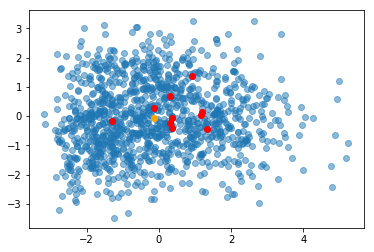

In [206]:
to_highlight = reduced_albums[reduced_albums['album_id']=='7CIc8keZ5tOKJMzYidj1qr']
plt.scatter(reduced_albums[0],reduced_albums[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='red')
plt.scatter(reduced_albums[0].mean(),reduced_albums[1].mean(), color='orange')

In [207]:
#What if the data wasn't reduced?
data.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'name',
       'preview_url', 'album_id', 'album_type', 'artist_id', 'image_300',
       'image_64', 'image_640', 'album_name', 'release_date', 'artist_name'],
      dtype='object')

In [208]:
Y.head()

acousticness  danceability    energy  instrumentalness  speechiness  \
0      1.848494     -0.220568 -1.686036         -0.434914    -0.427225   
1     -0.354503     -0.351195 -0.130713         -0.434609    -0.238026   
2      1.798639      0.123187 -1.650587         -0.434914    -0.304624   
3      1.935742     -0.399320 -1.358133         -0.434910    -0.528637   
4     -0.525882      0.824447  0.511800         -0.434813    -0.567990   

    valence  loudness     tempo  
0 -0.525403 -1.006968 -0.883558  
1 -1.068257 -0.300639  0.255556  
2 -0.808235 -0.237184 -0.429785  
3 -0.748931  0.151871  0.703155  
4  1.135093  0.615292 -0.321752

In [209]:
uniqueness_data_nonpca = pd.DataFrame(Y)
uniqueness_data_nonpca['id'] = data['id']
uniqueness_data_nonpca['name'] = data['name']
uniqueness_data_nonpca['artist_name'] = data['artist_name']
uniqueness_data_nonpca['album_id'] = data['album_id']
uniqueness_data_nonpca['album_name'] = data['album_name']
uniqueness_data_nonpca['album_type'] = data['album_type']
uniqueness_data_nonpca = uniqueness_data_nonpca[uniqueness_data_nonpca['album_type']=='album']

In [210]:
uniqueness_data_nonpca.head()

acousticness  danceability    energy  instrumentalness  speechiness  \
18      1.798639     -1.623087 -1.854419         -0.434909    -0.454470   
19     -0.997018     -1.038704 -0.152868         -0.434893    -0.508960   
20     -0.335807      0.102562  0.848565         -0.434914    -0.452957   
21      1.306314     -0.358070 -1.597414         -0.434914    -0.463552   
22      0.390216      0.686945  1.384731         -0.434914     0.126752   

     valence  loudness     tempo                      id  \
18 -0.885785 -0.957869  0.547315  0wUSZjJVblGKntOqBSWMdo   
19 -1.460116  0.581124 -1.122808  1PylPQlmQ2ymbRFtEqs3NM   
20  1.212644  0.614430  0.839354  461EfHiwzh8ZCZGaFEIaAJ   
21 -0.771740 -1.030225  1.031462  4ZMMxYeUfDcTbJrYbHYkH9   
22  1.573026  0.920793 -0.811267  2FdFtKCpMUVSyjfrisntqS   

                                                 name artist_name  \
18                                         Bawat Daan  Ebe Dancel   
19                                            Kasayaw  Ebe Dancel   
20                                               Prom  Ebe Dancel   
21  Hanggang Wala Nang Bukas - Theme from Heneral ...  Ebe Dancel   
22                                        Dapit-Hapon  Ebe Dancel   

                  album_id  album_name album_type  
18  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album  
19  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album  
20  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album  
21  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album  
22  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album

In [211]:
uniqueness_data_nonpca_std = uniqueness_data_nonpca.groupby('album_id').std().reset_index()
uniqueness_data_nonpca_std = reduced_albums[['album_id','artist_name','album_name']].drop_duplicates().merge(uniqueness_data_nonpca_std, on='album_id')
uniqueness_data_nonpca_std.head()

album_id       artist_name  \
0  4acHD3ykZw3DYLcLW1Mqv3        Ebe Dancel   
1  4bU263JJqschDhYZRgbnt7         Autotelic   
2  0oZlesVQj072lg8KM4ojFC          Sandwich   
3  46FVwz9NCaXlRWlBSx7LG4  B. P. Valenzuela   
4  2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   

                                        album_name  acousticness  \
0                                       Bawat Daan      1.107535   
1                                  Papunta Pabalik      0.372821   
2                                           Debris      0.962215   
3                                        Neon Hour      1.162002   
4  Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede      0.668162   

   danceability    energy  instrumentalness  speechiness   valence  loudness  \
0      0.767374  1.135346          0.001007     0.235314  1.007116  0.638386   
1      0.677218  0.820468          0.067273     0.284976  1.047987  0.561647   
2      1.077128  0.410268          0.742133     0.805866  0.719435  0.392893   
3      0.922444  1.522912          1.098758     0.287693  0.971936  2.181681   
4      0.652753  0.759453          1.288701     0.395488  1.004161  0.441043   

      tempo  
0  1.136439  
1  0.816911  
2  0.704016  
3  1.184976  
4  0.754973

In [212]:
uniqueness_data_nonpca_std['distance'] =[euclidean(uniqueness_data_nonpca_std.loc[x][col],np.zeros(8)) for x in range(len(uniqueness_data_nonpca_std))]
uniqueness_data_nonpca_std.head()

album_id       artist_name  \
0  4acHD3ykZw3DYLcLW1Mqv3        Ebe Dancel   
1  4bU263JJqschDhYZRgbnt7         Autotelic   
2  0oZlesVQj072lg8KM4ojFC          Sandwich   
3  46FVwz9NCaXlRWlBSx7LG4  B. P. Valenzuela   
4  2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   

                                        album_name  acousticness  \
0                                       Bawat Daan      1.107535   
1                                  Papunta Pabalik      0.372821   
2                                           Debris      0.962215   
3                                        Neon Hour      1.162002   
4  Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede      0.668162   

   danceability    energy  instrumentalness  speechiness   valence  loudness  \
0      0.767374  1.135346          0.001007     0.235314  1.007116  0.638386   
1      0.677218  0.820468          0.067273     0.284976  1.047987  0.561647   
2      1.077128  0.410268          0.742133     0.805866  0.719435  0.392893   
3      0.922444  1.522912          1.098758     0.287693  0.971936  2.181681   
4      0.652753  0.759453          1.288701     0.395488  1.004161  0.441043   

      tempo  distance  
0  1.136439  2.423468  
1  0.816911  1.854074  
2  0.704016  2.149919  
3  1.184976  3.594302  
4  0.754973  2.244838

In [213]:
uniqueness_data_nonpca_std.sort_values(by='distance').head(10)

album_id          artist_name          album_name  \
10  6K9V6MxhxQqwPjoxbyc2rE         Johnoy Danao         Samu't-Sari   
58  1UeeX7O8uWEkBpgLpi1C5S              Because      Heartbreak SZN   
38  4gyd2janVls7J3lX6WXdta      Maxine Tiongson     Maxine Tiongson   
71  05rQadwAVYTpNNnBoeTuj0     Moira Dela Torre              Malaya   
7   6iR6ubr14wcuF9VafyvUVg                Kjwan        IV Volume II   
50  2Dn1TPXD4QDrWXUnTghXn0           Poor Taste           Pure Dirt   
68  4UeWZpXENQJXluB6CBg6ZW           Karencitta  Cebuana Persuasion   
22  2iwjSLyvZJAogsvnKpaCov  Never The Strangers          Screenburn   
1   4bU263JJqschDhYZRgbnt7            Autotelic     Papunta Pabalik   
31  4syrgMPfhuA65cjB33THKl               Cheats   Before the Babies   

    acousticness  danceability    energy  instrumentalness  speechiness  \
10      0.535360      0.778942  0.426098          0.074137     0.136642   
58      0.520129      0.701448  0.466539          0.000109     0.057489   
38      0.056836      0.873805  0.204860          0.073119     0.144112   
71      0.027016      0.742465  0.392250          0.002261     0.470209   
7       0.828259      0.548802  0.863109          0.000020     0.087306   
50      0.469474      0.923341  0.311219          0.057564     0.736855   
68      0.010691      0.659597  0.383330          0.000228     0.259174   
22      0.922879      0.755518  0.721335          0.004391     0.174085   
1       0.372821      0.677218  0.820468          0.067273     0.284976   
31      0.675916      0.871148  0.646001          0.000212     0.504083   

     valence  loudness     tempo  distance  
10  0.803437  0.419756  0.379282  1.436889  
58  0.452437  0.485327  0.815077  1.445033  
38  0.540975  0.570886  0.813951  1.454624  
71  0.613099  0.365442  1.080551  1.613683  
7   0.525575  0.424521  0.729234  1.651667  
50  0.569029  0.616286  0.714519  1.711792  
68  0.740376  0.569547  1.281399  1.778713  
22  0.868545  0.534728  0.616850  1.842273  
1   1.047987  0.561647  0.816911  1.854074  
31  0.875202  0.485703  0.748992  1.857432

In [214]:
uniqueness_data_nonpca_std.sort_values(by='distance', ascending=False).head(10)

album_id        artist_name            album_name  \
80   6K3zUrIHmP0p6fj5zUSNQe           Typecast     Campfire Sessions   
15   27jcbwKc8QCupGH2D0HXLX            Apartel  Inner Play (Remixes)   
79   5brVpbx6EHrmyoVb5dS2PY   Valley of Chrome            Dark Horse   
3    46FVwz9NCaXlRWlBSx7LG4   B. P. Valenzuela             Neon Hour   
64   7z2DVbUC9iLaBZe8mTmmE1    Nights of Rizal           summer/salt   
61   4WtiljJg8by8qPi5Hrgrcx   We Are Imaginary  Death to Romanticism   
56   0EPue1OBoRjRYpgQ3wLreE         James Reid           Palm Dreams   
100  3Lil4hR6tuUteKCy93VVBs   Glaiza De Castro    Magandang Simulain   
85   7qrkSYUV0iE6V0RsD7SWxQ  Assembly Generals     Assembly Generals   
33   2KzwyXW4u2MewGOnioHyT0              Pupil                 Zilch   

     acousticness  danceability    energy  instrumentalness  speechiness  \
80       1.042951      1.267197  1.024263          1.533881     2.316552   
15       0.772154      0.710521  0.744578          0.014156     2.818320   
79       0.991819      1.334995  1.707947          1.520873     1.302405   
3        1.162002      0.922444  1.522912          1.098758     0.287693   
64       1.197023      1.241763  1.236960          1.723315     0.247258   
61       1.019764      1.341450  0.731045          1.394331     2.089883   
56       1.300658      0.667543  1.260889          1.561642     0.823447   
100      1.171891      0.812299  0.837879          1.679423     1.389322   
85       1.043918      0.820479  0.555304          0.580387     2.248812   
33       0.766666      1.145460  0.762008          0.000067     2.235827   

      valence  loudness     tempo  distance  
80   1.319734  0.821954  1.468764  4.004551  
15   1.101773  1.145095  1.378191  3.744749  
79   0.643495  1.574304  1.054445  3.700904  
3    0.971936  2.181681  1.184976  3.594302  
64   0.733181  1.747547  1.100754  3.512691  
61   1.002422  0.479266  1.158025  3.501596  
56   0.776137  1.839628  0.474978  3.325084  
100  1.086313  1.031372  1.063794  3.295654  
85   0.950232  0.753762  1.341597  3.276629  
33   0.819947  0.957312  1.270348  3.268329

Both the PCA-reduced and non-PCA datasets share some albums that rank low in uniqueness. We'll go with the dataset that went through dimensionality reduction since computing distance gets unreliable in higher dimensions (curse of dimensionality). 

We could also try grouping the tracks by artists to measure how varied their songs are and see how artists evolve over time. However, this would require the artists whole discography, which is beyond the scope of this project. It's an interesting idea for a another project though.  

In [215]:
reduced_top_tracks = reduced_data.merge(top_tracks[['popularity','id']], on='id')
reduced_top_tracks.head()

0         1                      id  \
0  2.728120  0.077825  3kFDnFj6asUJsUPodsWT2o   
1  2.284328 -0.011178  2IFNR24j14O8IuqLxFr0NT   
2  2.284328 -0.011178  2IFNR24j14O8IuqLxFr0NT   
3  1.734308 -0.872133  4FrzR2A8kmSKB87Nx2oZjR   
4  1.734308 -0.872133  4FrzR2A8kmSKB87Nx2oZjR   

                                    name      artist_name  \
0  Away from the Current (Piano Version)  Keiko Necesario   
1                      Let Me Be The One  Keiko Necesario   
2                      Let Me Be The One  Keiko Necesario   
3                            Ikaw Pa Rin  Keiko Necesario   
4                            Ikaw Pa Rin  Keiko Necesario   

                 album_id                                         album_name  \
0  7Lnn2od0JUFPDM6H9RXPBQ              Away from the Current (Piano Version)   
1  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
2  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
3  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
4  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   

  album_type  popularity  
0     single        28.0  
1     single        55.0  
2     single        55.0  
3     single        53.0  
4     single        53.0

In [216]:
reduced_top_tracks['popularity'].describe()

count    1291.00000
mean       21.01859
std        16.22878
min         0.00000
25%         7.00000
50%        19.00000
75%        32.00000
max        72.00000
Name: popularity, dtype: float64

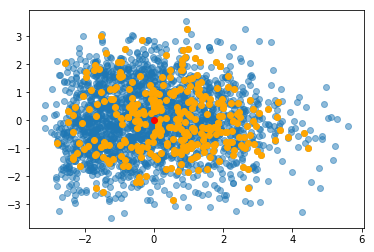

In [217]:
to_highlight = reduced_top_tracks[reduced_top_tracks['popularity'] >= 32] #32 for the 75th percentile
plt.scatter(reduced_data[0],reduced_data[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='orange')
plt.scatter(reduced_data[0].mean(),reduced_data[1].mean(), color='red')

The 25% most popular tracks don't seem to cluster in a particular area. It all looks spread out.

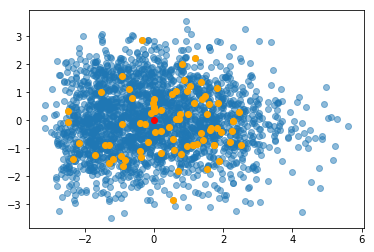

In [218]:
to_highlight = reduced_top_tracks[reduced_top_tracks['popularity'] >= 50] 
plt.scatter(reduced_data[0],reduced_data[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='orange')
plt.scatter(reduced_data[0].mean(),reduced_data[1].mean(), color='red')

No clear pattern here either.

In [219]:
#is there a correlation between album type and popularity?
enc = OneHotEncoder(handle_unknown='ignore')
output = enc.fit_transform(np.array(reduced_top_tracks['album_type']).reshape(-1,1))
reduced_top_tracks['album_type_onehot'] = np.zeros(len(reduced_top_tracks))
reduced_top_tracks['album_type_onehot'] = output.toarray()

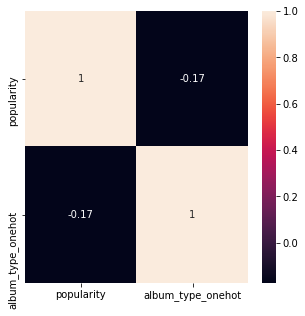

In [220]:
plt.figure(figsize=(5, 5))
corr = reduced_top_tracks[['popularity','album_type_onehot']].corr()
sns.heatmap(corr, 
            xticklabels=reduced_top_tracks[['popularity','album_type_onehot']].columns.values,
            yticklabels=reduced_top_tracks[['popularity','album_type_onehot']].columns.values,
            annot=True)

There's no correlation between album type and popularity.

## Track Similarity

In [221]:
#tracks the most like each other: find the track's nearest neighbor, then rank distance
nbrs = NearestNeighbors(n_neighbors=2).fit(np.array(reduced_data[[0,1]]))
distances, indices = nbrs.kneighbors(np.array(reduced_data[[0,1]]))
reduced_data['nn_distance'] = distances[:,1]
reduced_data['closest_track'] = indices[:,1]

In [222]:
reduced_data.sort_values(by='nn_distance')

0         1                      id  \
1570  2.007811  0.537595  0L5trrvKANNsgBmdScEDzr   
1826  2.007950  0.536116  159J9giehAOVKAeZ8Q03yF   
853  -1.314255  1.098776  52MJAMmwvoeqfhPRfzTf6n   
1494 -1.312648  1.097962  7fefE5Xy8CYA7Runo4cwLh   
176  -1.294741 -0.874565  4yLc803i7qcWx4V2piWPH5   
511  -1.294602 -0.876540  6cd2VmIzuU7RYT28xoIgvI   
1709 -2.157726 -0.820511  74PAh4VOn2sNHlb0IDhiqF   
133  -2.155407 -0.820207  5LzCfzSK1MS46s0KAF4gM2   
1508 -1.179954  0.157081  4yUC7miTl4hrl2KzTLfYIW   
1192 -1.178241  0.155401  7hzKVi4RxS7bbwzyyl5WYG   
681  -0.909654 -0.134367  6PnWfLrXppGscQKYWSn95a   
826  -0.912294 -0.135707  33NwLcrJHLbENMoDeAPUNi   
1580  1.225381  1.054322  7zRCu2Umy7KMpd09VVPNXT   
1054  1.224706  1.051292  57SBBhaQXUoI6O7OZ9njQq   
696   1.565651 -1.612967  0jK9vBh4vu8ozgNsc7cLiU   
1350  1.561360 -1.611149  3IEc6Gggiqv8SGEDIHQ6aA   
1190  1.213974 -1.146378  1ImxT8igCBRzHrsD64aaeG   
1195  1.213167 -1.151667  6d4egRrjeLdAxlvHg2VHpe   
89   -2.495241 -0.050116  0C3uSpHrmzYDi3wYQuZDaM   
38   -2.494579 -0.055798  0FOYt3VRWweAWgN1relGqN   
1509 -1.484909  1.294717  6Z0icNzpaKR3ExPOA3QItS   
2092 -1.487512  1.289129  6qlPmZp3k06R0jMJYNQYuj   
1986  1.296163  0.899827  5jy6yaxj3PobGM786YmteJ   
2039  1.296616  0.893540  3DKvf6aIw6FlzdqNt14mPV   
1555  0.109473  0.569364  6T1dsOvuTpYNs7FKtZ5U7o   
1108  0.102668  0.567921  6lF9wpsIKagTsRME1xtPsd   
689  -0.685199  1.304575  4Acdd61z1lYbk7eOO9teX7   
1359 -0.691626  1.308330  3XXrbXc0tpNPJ6hanS18Mw   
473   0.684410 -0.128583  4apKgUkjGYZHVuU4KqqzkR   
1686  0.684476 -0.136207  2O4IUJkzxYF0WjT0cbx7ZG   
...        ...       ...                     ...   
342   3.374098  2.812486  4t1o4zOPkZGBZObqiV5PlF   
2120  3.044758  2.828106  1Ou5QEWtdOG79E1grrMJr4   
1212  2.284601  2.606036  37PJZIV293v9ujRR7j0tPv   
1047  4.788261 -2.415827  735ASYOVlK4fcyzR9zculW   
1320  4.526917 -2.206105  5gi4t6gM1I8JxrUWW3CIN7   
2119  4.407229  0.468936  6YntHaucpEvRln2j6c5Dhf   
2003 -3.159356  0.540528  6MGUFOrPDMGV0zjbn4Yf37   
1289  3.375685  1.269494  1jlO9wxjfdVFI4nnog8tVx   
2115  3.681023  1.110715  7epTWaBsNxG1ZWCj0cljNK   
931   0.969996 -3.095751  1lvntOJSmFMkOaVZK7WB3V   
312   3.937108  0.318479  2HpNbwcZOYBbFY31tItqsL   
1113  3.309173 -2.148541  1QE8p6gTOkJNIuJFzJJvLt   
2001 -2.942630  1.128622  76g7udD2CSi7nD8to0UcUZ   
1743  3.697488 -1.434279  4A9GYQKBuBcVyBf3gOpI15   
845   1.612056 -3.075673  2Hy9MCSfcSgGygeUdwFC1i   
1896 -0.865257 -3.297491  2vyg9lcxdo711hmc6PWqLh   
1301 -1.242841 -3.468407  4C7n36BL9zjlmnqM4eNGlg   
1952  5.615921 -0.214522  4HSkDVD24bpyPj4uFqhzp7   
1736 -2.058328  3.005251  0lpqMqwJYj2aYScN9E90VG   
1564  5.239802 -0.924688  4fYm9j0RjWEDMuFj112TOW   
764   2.372858 -3.252500  2F45e6dcTWbmimZqNWfAOX   
1649 -2.753827 -3.226610  41zpSuqIqjf9YvgqX7GRua   
1557  5.187773 -1.417891  7BwbWnYny63V6GP0QkxISJ   
1567  3.995561 -1.839122  5auFt32xYdzbA7I62M6hX7   
242   4.775906 -1.715301  7GdDs5MunB6OiOpbDxGhgh   
888   4.916854  0.599418  6BtESRLoC3cDlrkZXjt4cc   
2113  3.440115  1.809351  3R8xZOTSRmdyZpNkANVXwy   
1274  2.643302  3.262140  7BO3DIefDbEIYbyvzAsmbW   
1898  4.984663  1.193439  1lKR9pAKnFyyzjiVLnrKtm   
1122  4.273715 -3.255753  1a1ARruRuYn3N8PJK0hjbp   

                                                   name  \
1570                                        WSK (Wasak)   
1826                                          Apollo 11   
853                                      Favorite Donut   
1494                        Love Me Instead (31° Remix)   
176   Magkunwari ('Di Man Tayo) [TODA One I Love Off...   
511                                          Live Again   
1709                                           Run Away   
133                                Jopay (2014 Version)   
1508                                         Moonstruck   
1192                                             Bulong   
681                                     Like We Used To   
826                                        Bagong Umaga   
1580                 

In [223]:
reduced_data['closest_track_id'] = [reduced_data.id.iloc[x] for x in reduced_data.closest_track]

## Album Similarity

In [224]:
#get the mean per album
reduced_albums_mean = reduced_albums.groupby('album_id').mean()#.reset_index()
reduced_albums_mean = reduced_albums[['album_id','artist_name','album_name']].drop_duplicates().merge(reduced_albums_mean, on='album_id')
reduced_albums_mean.head()

album_id       artist_name  \
0  4acHD3ykZw3DYLcLW1Mqv3        Ebe Dancel   
1  4bU263JJqschDhYZRgbnt7         Autotelic   
2  0oZlesVQj072lg8KM4ojFC          Sandwich   
3  46FVwz9NCaXlRWlBSx7LG4  B. P. Valenzuela   
4  2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   

                                        album_name         0         1  
0                                       Bawat Daan -0.056570 -0.931400  
1                                  Papunta Pabalik -1.719190 -0.256150  
2                                           Debris -1.549406 -0.696811  
3                                        Neon Hour  0.395978  0.142717  
4  Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede -0.645426 -0.666115

In [225]:
nbrs = NearestNeighbors(n_neighbors=2).fit(np.array(reduced_albums_mean[[0,1]]))
distances, indices = nbrs.kneighbors(np.array(reduced_albums_mean[[0,1]]))
reduced_albums_mean['nn_distance'] = distances[:,1]
reduced_albums_mean['closest_album'] = indices[:,1]

In [226]:
reduced_albums_mean.sort_values(by='nn_distance')

album_id          artist_name  \
4    2ccGiBe4kDrOdnRA0IMLlo           Mayonnaise   
94   0vcQFrvxE5pRydF8melgjK      The Strangeness   
51   7ESfHenLYEtdxK54gCLCQI        Jess Connelly   
106  0DWKo3p5bQSV3td2etejXJ          Kai Honasan   
100  3Lil4hR6tuUteKCy93VVBs     Glaiza De Castro   
75   1fhIqZTgAKsfEeNfzVHyZ6               lluwin   
31   4syrgMPfhuA65cjB33THKl               Cheats   
73   3GwrMqo0vtxXCLFX8QbS8R        Paranoid City   
37   3OcqPxNEmY7lyZ1qkITNvF          Vincent Eco   
102  4hUlZx7Ft7mUwQcrj89Pib               Chlara   
26   2pn8NEN9jfmMpyC3bwQ9Cj           The Cohens   
22   2iwjSLyvZJAogsvnKpaCov  Never The Strangers   
3    46FVwz9NCaXlRWlBSx7LG4     B. P. Valenzuela   
60   7CIc8keZ5tOKJMzYidj1qr      Chocolate Grass   
47   1w5IWoOr276Clr1d4pynDR        Absolute Play   
108  0ab6fhMmKWtTfczaxprpiy          Rap Sanchez   
61   4WtiljJg8by8qPi5Hrgrcx     We Are Imaginary   
8    2xDMXQrLcUxzsAdpdlLPZh      December Avenue   
38   4gyd2janVls7J3lX6WXdta      Maxine Tiongson   
20   23AHziIJvdpUYzVQSwYbmN   Jensen & The Flips   
12   08nQUfuftB2KzgfTZNld8A      MilesExperience   
110  3e6pYeZ68Meg6gUhLmzuyv    Starlight Replica   
69   5mGR6qKnpILzSzq1yyAUXk         IV Of Spades   
104  4S7185A9GtZI3zstkLu6gr        June Marieezy   
50   2Dn1TPXD4QDrWXUnTghXn0           Poor Taste   
54   1aJbQCeI5FKCl4XGpoCIIh     Kiana Valenciano   
46   7I1wTE68YnrLZ9Vcq4Pm44            Idle Sean   
68   4UeWZpXENQJXluB6CBg6ZW           Karencitta   
92   5gVcRDhAf2xFpBCzRMAMDO        The Buildings   
25   7s3E53Kp9elnqtLEuaJLDA  Ang Bandang Shirley   
..                      ...                  ...   
59   60qph1sDjhgZtPR4IEnu5Y               UNIQUE   
34   7kzETZloUVbyQLuqDnLPVV        Join The Club   
96   0mtpfq2CcZd22PAgjx3K2g       Pastilan Dong!   
62   7ajTPoL2oITt9owfDla2te             LUSTBASS   
18   4udjiMxdYw8SGansxRzTZZ      Reese Lansangan   
58   1UeeX7O8uWEkBpgLpi1C5S              Because   
64   7z2DVbUC9iLaBZe8mTmmE1      Nights of Rizal   
36   4BhzClilLBs9uWio8AruO9        Edward Barber   
45   2zh3x7VmJ1vmzfbbSp12Fl            Idle Sean   
76   13vapJJUG4b1an7XNR56Hz           123 Pikit!   
86   48AYNO8eqr5opiLA6eQKK3            Outerhope   
27   0N8PyfQJgquTjUcFZyt2VF   She's Only Sixteen   
41   3XqdqlHc7ih2pHHZbWWZ1B            The Juans   
52   4n7JDVgx22y8S3can1mSjk                 crwn   
74   6rnuciqkf0WUAzPE5P9qW7        Runway Crimes   
0    4acHD3ykZw3DYLcLW1Mqv3           Ebe Dancel   
99   0kaULzpPe7UGxacdVaVtOJ          Clara Benin   
17   7hu1r0fiuTrexsDOfr9Nnl        Banna Harbera   
53   3SrqGYBJ6MaJ7QZu8yTZSN           Curtismith   
80   6K3zUrIHmP0p6fj5zUSNQe             Typecast   
13   0sw9b2xhLKM9TTEug2uPCE      MilesExperience   
67   0ZxoADRrygmrVAo5DJOogM                NINNO   
21   1bpwXTiOGW1TZ60AoJ00WW   Jensen & The Flips   
84   7i8cfv0rwUaJ0Q1KTTl7IM    Assembly Generals   
85   7qrkSYUV0iE6V0RsD7SWxQ    Assembly Generals   
78   3KwPmP7ZXMhsimCTaFWmv0     Valley of Chrome   
14   7Hqau1yMgvbFTuAUOpRjtb              Apartel   
70   21kXGGOQET9ll4NGhs2SOg  I Belong to the Zoo   
7    6iR6ubr14wcuF9VafyvUVg                Kjwan   
105  23pYV2apggrLkpgcSerfuD          Alex Corner   

                                          album_name         0         1  \
4    Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede -0.645426 -0.666115   
94             Scorned as Timber, Beloved of the Sky -0.660640 -0.653215   
51                                              JCON  0.493508  0.594889   
106     In Your Face & Other Songs About Other Faces  0.476865  0.611212   
100                               Magandang Simulain  1.254817 -0.219666   
75                                 Naritokanangapala  1.262247 -0.185837   
31                                 Before the Babies -0.375441 -0.649078   
73                                      Metropolitan -0.322474 -0.633081   
37                                  Kiss & Disappear  1.413735 -0.272054   
102                             In

It's a hit and miss for this one. Most of the albums share little similarities with the closest album.

### Exporting data for visualization

In [227]:
#edit tracks that share artists
data_multiple_merged = data_multiple_artists.groupby(['id'])['artist_name'].apply(', '.join).reset_index()
to_add = data[data.id.isin(data_multiple_merged.id)].drop(columns=["artist_name"]).merge(data_multiple_merged, on="id")
data = data[~data.id.isin(data_multiple_merged.id)]
data = data.append(to_add)

In [228]:
data = data.merge(reduced_data[[0,1,'id','nn_distance','closest_track_id']], on='id')

In [229]:
data = data.merge(reduced_albums_std[['album_id','album_distance']], how='left', on='album_id').rename(columns={0: "zero", 1: "one"})

In [230]:
data[col] = data[col].round(2)
data[["tempo","loudness"]] = data[["tempo","loudness"]].round()

In [231]:
data.to_csv('phindie.csv', index=False)